In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/NEUROCIRUGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=149.1, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 408
Page 1, Q1, A: Yellow percentage: 0.0%


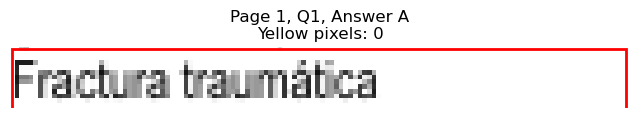

Page 1, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=173.7, y1=152.6
Page 1, Q1, B: Yellow pixels: 1624
Page 1, Q1, B: Total non-white pixels: 2184
Page 1, Q1, B: Yellow percentage: 74.4%


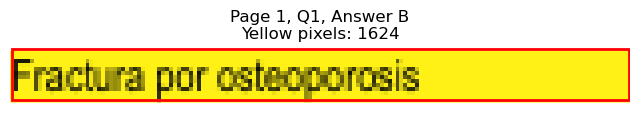

Page 1, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=373.3, y1=139.9
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 248
Page 1, Q1, C: Yellow percentage: 0.0%


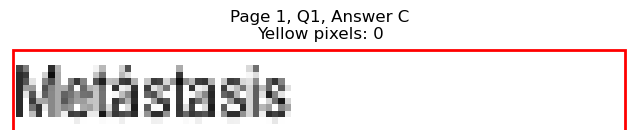

Page 1, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=420.3, y1=152.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 447
Page 1, Q1, D: Yellow percentage: 0.0%


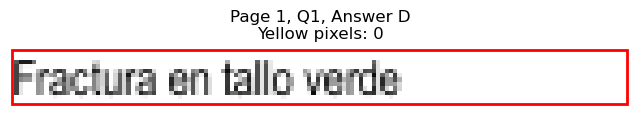


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=103.9, y1=190.4
Page 1, Q2, A: Yellow pixels: 86
Page 1, Q2, A: Total non-white pixels: 257
Page 1, Q2, A: Yellow percentage: 33.5%


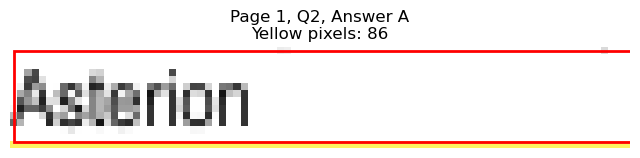

Page 1, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=126.5, y1=203.0
Page 1, Q2, B: Yellow pixels: 1169
Page 1, Q2, B: Total non-white pixels: 1417
Page 1, Q2, B: Yellow percentage: 82.5%


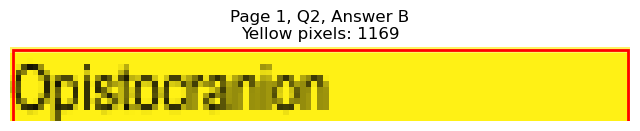

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=349.6, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 109
Page 1, Q2, C: Yellow percentage: 0.0%


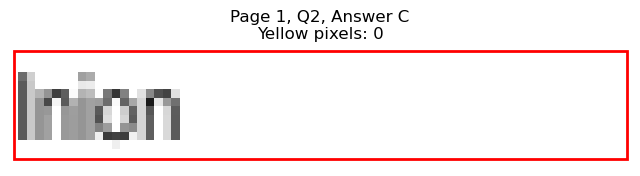

Page 1, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=358.6, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 157
Page 1, Q2, D: Yellow percentage: 0.0%


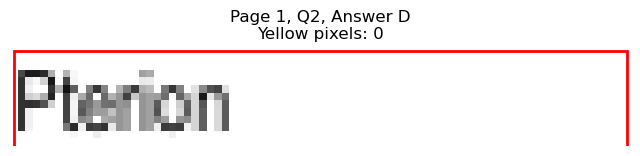


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=93.9, y1=240.9
Page 1, Q3, A: Yellow pixels: 894
Page 1, Q3, A: Total non-white pixels: 988
Page 1, Q3, A: Yellow percentage: 90.5%


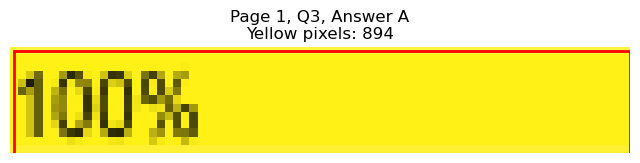

Page 1, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=88.8, y1=253.5
Page 1, Q3, B: Yellow pixels: 71
Page 1, Q3, B: Total non-white pixels: 175
Page 1, Q3, B: Yellow percentage: 40.6%


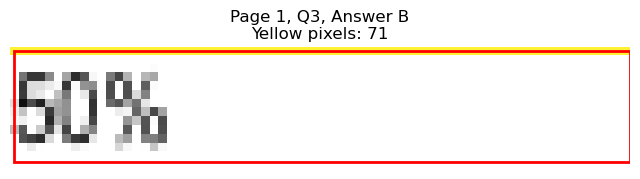

Page 1, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=348.1, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 99
Page 1, Q3, C: Yellow percentage: 0.0%


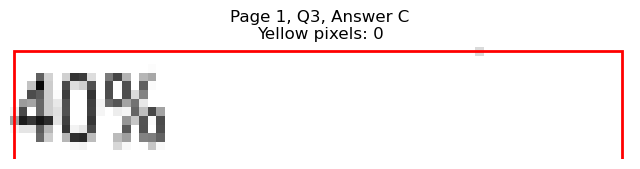

Page 1, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=348.1, y1=253.5
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 99
Page 1, Q3, D: Yellow percentage: 0.0%


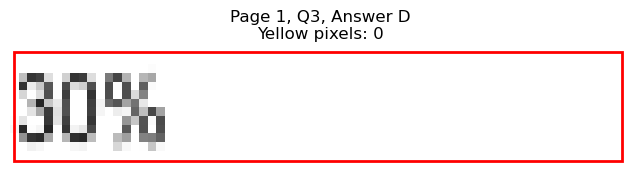


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=161.1, y1=316.7
Page 1, Q4, A: Yellow pixels: 1490
Page 1, Q4, A: Total non-white pixels: 1872
Page 1, Q4, A: Yellow percentage: 79.6%


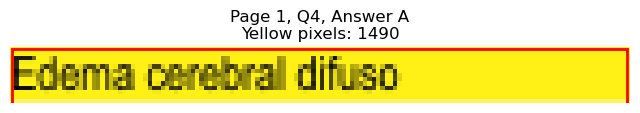

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=153.0, y1=329.3
Page 1, Q4, B: Yellow pixels: 136
Page 1, Q4, B: Total non-white pixels: 551
Page 1, Q4, B: Yellow percentage: 24.7%


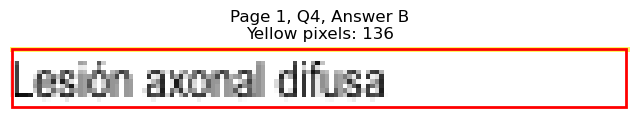

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=387.8, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 301
Page 1, Q4, C: Yellow percentage: 0.0%


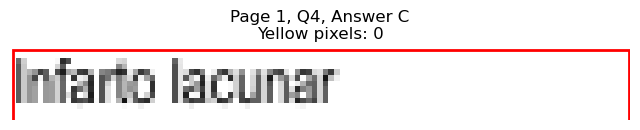

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=403.3, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 372
Page 1, Q4, D: Yellow percentage: 0.0%


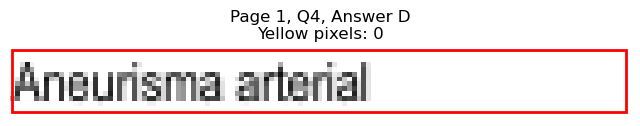


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=129.5, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 320
Page 1, Q5, A: Yellow percentage: 0.0%


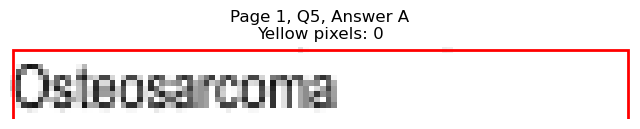

Page 1, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=138.5, y1=417.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 346
Page 1, Q5, B: Yellow percentage: 0.0%


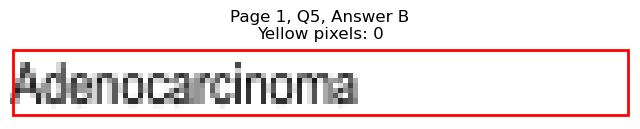

Page 1, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=362.1, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 232
Page 1, Q5, C: Yellow percentage: 0.0%


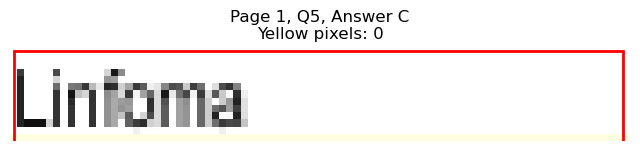

Page 1, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=372.2, y1=417.6
Page 1, Q5, D: Yellow pixels: 1057
Page 1, Q5, D: Total non-white pixels: 1344
Page 1, Q5, D: Yellow percentage: 78.6%


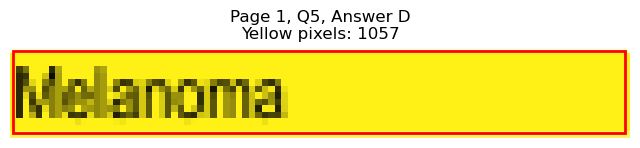


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=101.1, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 163
Page 1, Q6, A: Yellow percentage: 0.0%


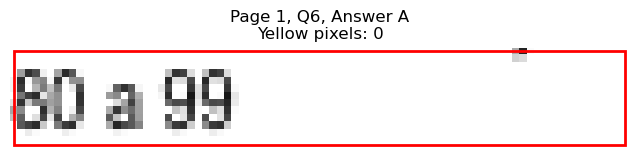

Page 1, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=110.9, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 195
Page 1, Q6, B: Yellow percentage: 0.0%


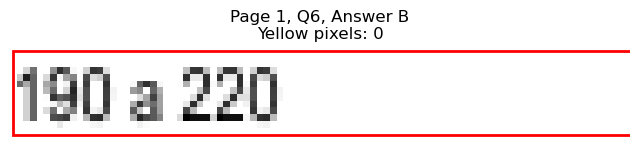

Page 1, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=370.3, y1=455.5
Page 1, Q6, C: Yellow pixels: 1081
Page 1, Q6, C: Total non-white pixels: 1316
Page 1, Q6, C: Yellow percentage: 82.1%


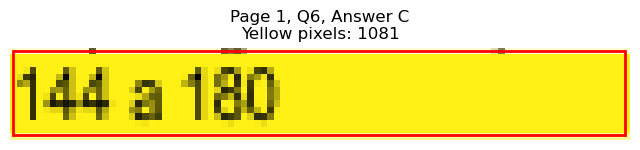

Page 1, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=365.2, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 174
Page 1, Q6, D: Yellow percentage: 0.0%


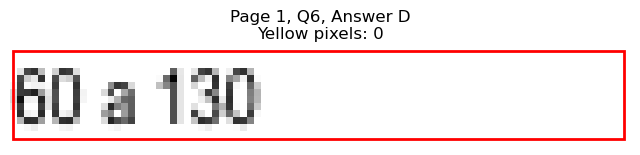


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=118.0, y1=518.6
Page 1, Q7, A: Yellow pixels: 1089
Page 1, Q7, A: Total non-white pixels: 1400
Page 1, Q7, A: Yellow percentage: 77.8%


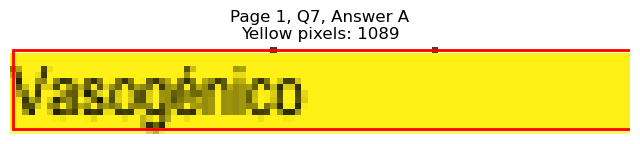

Page 1, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=121.9, y1=531.2
Page 1, Q7, B: Yellow pixels: 103
Page 1, Q7, B: Total non-white pixels: 399
Page 1, Q7, B: Yellow percentage: 25.8%


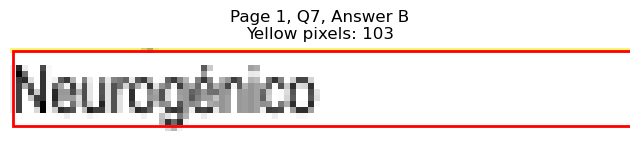

Page 1, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=370.6, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 235
Page 1, Q7, C: Yellow percentage: 0.0%


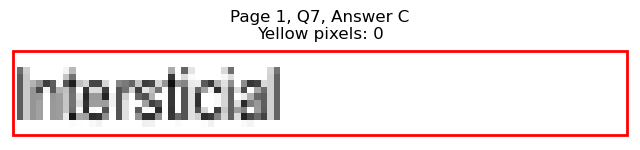

Page 1, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=369.7, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 222
Page 1, Q7, D: Yellow percentage: 0.0%


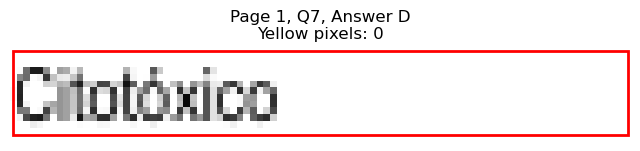


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=262.5, y1=581.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 981
Page 1, Q8, A: Yellow percentage: 0.0%


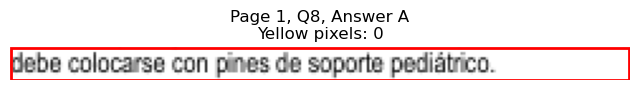

Page 1, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=259.0, y1=594.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 932
Page 1, Q8, B: Yellow percentage: 0.0%


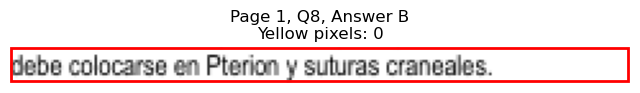

Page 1, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=492.1, y1=581.8
Page 1, Q8, C: Yellow pixels: 1
Page 1, Q8, C: Total non-white pixels: 1072
Page 1, Q8, C: Yellow percentage: 0.1%


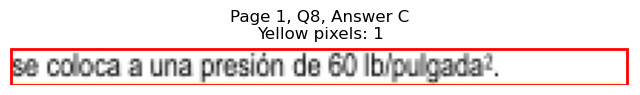

Page 1, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=522.2, y1=594.4
Page 1, Q8, D: Yellow pixels: 1862
Page 1, Q8, D: Total non-white pixels: 2996
Page 1, Q8, D: Yellow percentage: 62.1%


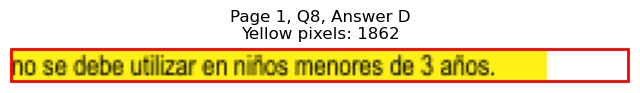


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=94.3, y1=644.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 138
Page 1, Q9, A: Yellow percentage: 0.0%


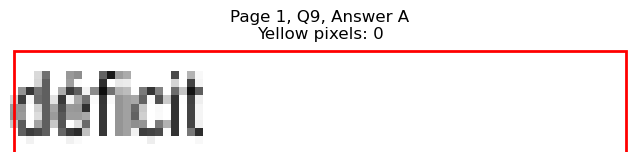

Page 1, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=100.9, y1=657.5
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 164
Page 1, Q9, B: Yellow percentage: 0.0%


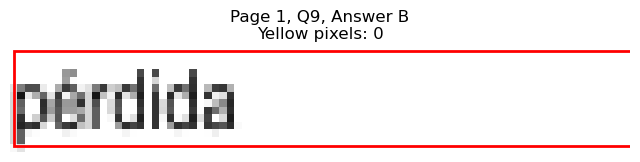

Page 1, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=377.7, y1=644.9
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 338
Page 1, Q9, C: Yellow percentage: 0.0%


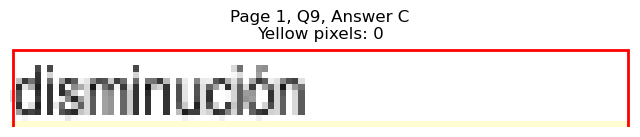

Page 1, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=365.2, y1=657.5
Page 1, Q9, D: Yellow pixels: 1024
Page 1, Q9, D: Total non-white pixels: 1246
Page 1, Q9, D: Yellow percentage: 82.2%


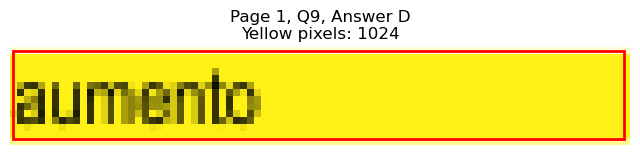


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=121.5, y1=720.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 289
Page 1, Q10, A: Yellow percentage: 0.0%


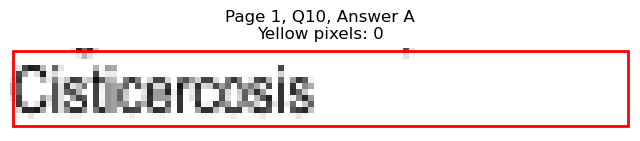

Page 1, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=176.1, y1=733.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 558
Page 1, Q10, B: Yellow percentage: 0.0%


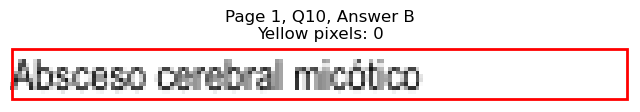

Page 1, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=433.9, y1=720.6
Page 1, Q10, C: Yellow pixels: 1620
Page 1, Q10, C: Total non-white pixels: 2198
Page 1, Q10, C: Yellow percentage: 73.7%


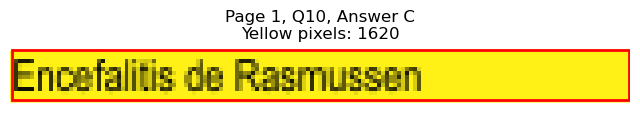

Page 1, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=385.7, y1=733.2
Page 1, Q10, D: Yellow pixels: 109
Page 1, Q10, D: Total non-white pixels: 407
Page 1, Q10, D: Yellow percentage: 26.8%


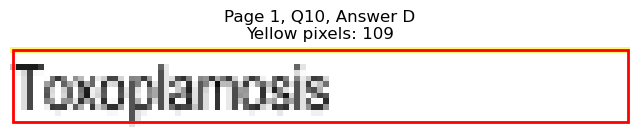


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=310.0, y1=127.3
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 1221
Page 2, Q1, A: Yellow percentage: 0.0%


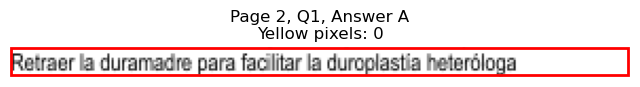

Page 2, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=265.8, y1=139.9
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 982
Page 2, Q1, B: Yellow percentage: 0.0%


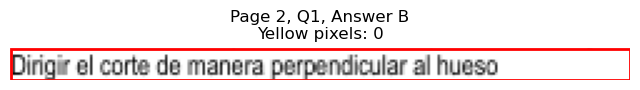

Page 2, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=212.8, y1=152.6
Page 2, Q1, C: Yellow pixels: 195
Page 2, Q1, C: Total non-white pixels: 927
Page 2, Q1, C: Yellow percentage: 21.0%


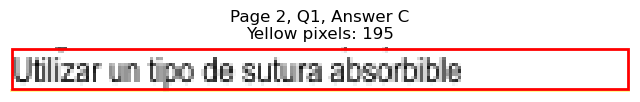

Page 2, Q1 - D: Detected box: x0=68.8, y0=152.5, x1=315.2, y1=165.2
Page 2, Q1, D: Yellow pixels: 2937
Page 2, Q1, D: Total non-white pixels: 4172
Page 2, Q1, D: Yellow percentage: 70.4%


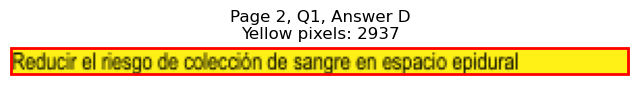


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=137.1, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 509
Page 2, Q2, A: Yellow percentage: 0.0%


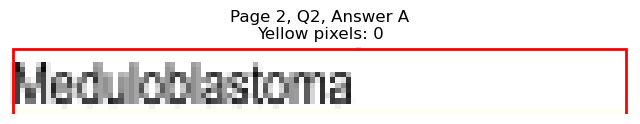

Page 2, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=168.1, y1=215.6
Page 2, Q2, B: Yellow pixels: 1558
Page 2, Q2, B: Total non-white pixels: 2114
Page 2, Q2, B: Yellow percentage: 73.7%


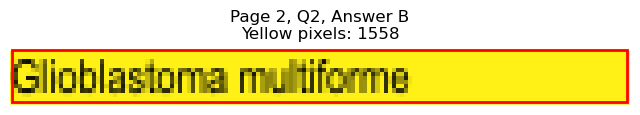

Page 2, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=413.3, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 461
Page 2, Q2, C: Yellow percentage: 0.0%


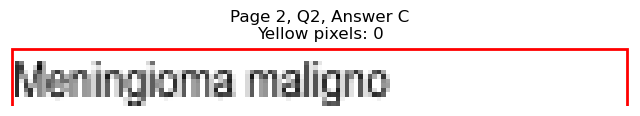

Page 2, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=412.9, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 436
Page 2, Q2, D: Yellow percentage: 0.0%


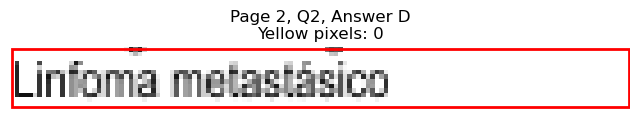


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=227.8, y1=278.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 835
Page 2, Q3, A: Yellow percentage: 0.0%


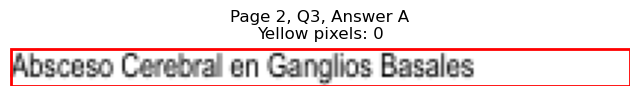

Page 2, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=173.5, y1=291.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 505
Page 2, Q3, B: Yellow percentage: 0.0%


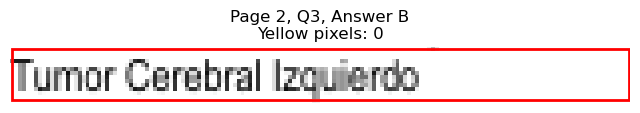

Page 2, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=444.4, y1=278.7
Page 2, Q3, C: Yellow pixels: 1707
Page 2, Q3, C: Total non-white pixels: 2184
Page 2, Q3, C: Yellow percentage: 78.2%


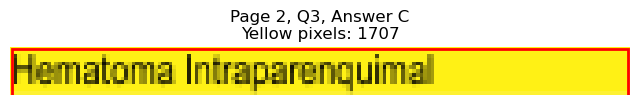

Page 2, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=469.9, y1=291.5
Page 2, Q3, D: Yellow pixels: 193
Page 2, Q3, D: Total non-white pixels: 883
Page 2, Q3, D: Yellow percentage: 21.9%


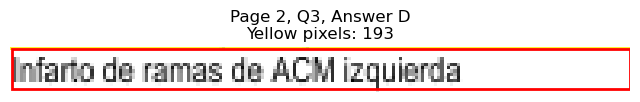


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=219.8, y1=329.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 752
Page 2, Q4, A: Yellow percentage: 0.0%


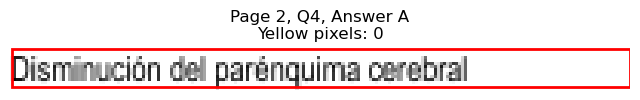

Page 2, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=230.3, y1=341.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 794
Page 2, Q4, B: Yellow percentage: 0.0%


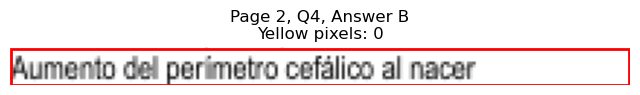

Page 2, Q4 - C: Detected box: x0=68.8, y0=341.9, x1=305.6, y1=354.6
Page 2, Q4, C: Yellow pixels: 2907
Page 2, Q4, C: Total non-white pixels: 4032
Page 2, Q4, C: Yellow percentage: 72.1%


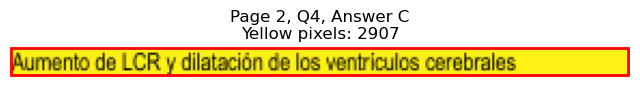

Page 2, Q4 - D: Detected box: x0=68.8, y0=354.5, x1=195.7, y1=367.2
Page 2, Q4, D: Yellow pixels: 177
Page 2, Q4, D: Total non-white pixels: 832
Page 2, Q4, D: Yellow percentage: 21.3%


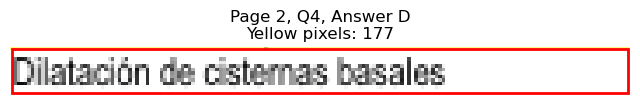


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=107.9, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 196
Page 2, Q5, A: Yellow percentage: 0.0%


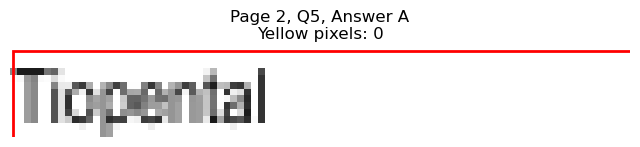

Page 2, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=104.4, y1=417.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 197
Page 2, Q5, B: Yellow percentage: 0.0%


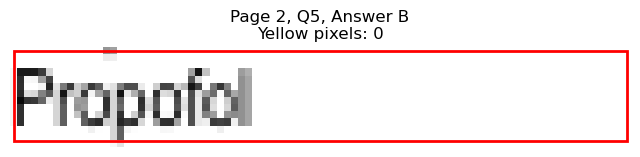

Page 2, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=368.2, y1=405.0
Page 2, Q5, C: Yellow pixels: 1045
Page 2, Q5, C: Total non-white pixels: 1196
Page 2, Q5, C: Yellow percentage: 87.4%


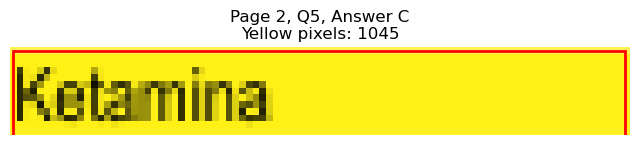

Page 2, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=370.6, y1=417.6
Page 2, Q5, D: Yellow pixels: 94
Page 2, Q5, D: Total non-white pixels: 314
Page 2, Q5, D: Yellow percentage: 29.9%


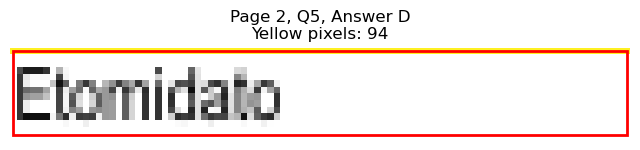


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=127.5, y1=468.1
Page 2, Q6, A: Yellow pixels: 110
Page 2, Q6, A: Total non-white pixels: 437
Page 2, Q6, A: Yellow percentage: 25.2%


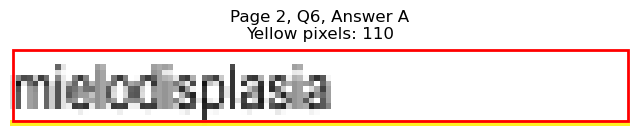

Page 2, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=123.5, y1=480.7
Page 2, Q6, B: Yellow pixels: 1152
Page 2, Q6, B: Total non-white pixels: 1378
Page 2, Q6, B: Yellow percentage: 83.6%


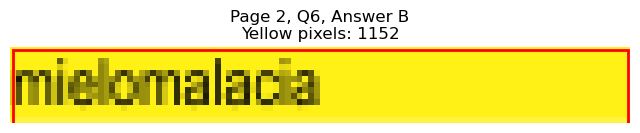

Page 2, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=395.7, y1=468.1
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 352
Page 2, Q6, C: Yellow percentage: 0.0%


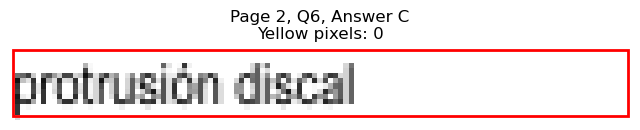

Page 2, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=392.2, y1=480.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 340
Page 2, Q6, D: Yellow percentage: 0.0%


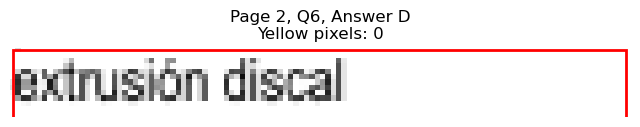


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=99.9, y1=518.6
Page 2, Q7, A: Yellow pixels: 82
Page 2, Q7, A: Total non-white pixels: 249
Page 2, Q7, A: Yellow percentage: 32.9%


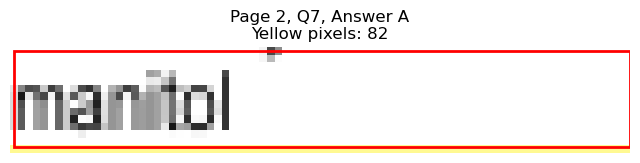

Page 2, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=130.5, y1=531.2
Page 2, Q7, B: Yellow pixels: 1230
Page 2, Q7, B: Total non-white pixels: 1582
Page 2, Q7, B: Yellow percentage: 77.7%


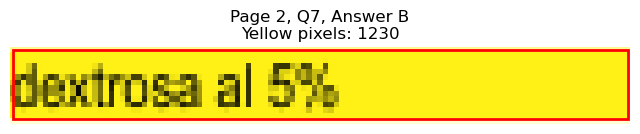

Page 2, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=409.9, y1=518.6
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 449
Page 2, Q7, C: Yellow percentage: 0.0%


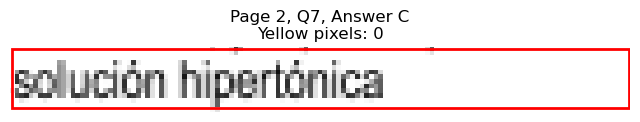

Page 2, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=373.1, y1=531.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 241
Page 2, Q7, D: Yellow percentage: 0.0%


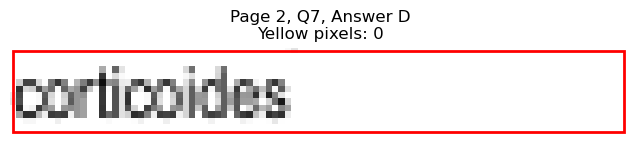


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=135.0, y1=581.8
Page 2, Q8, A: Yellow pixels: 1267
Page 2, Q8, A: Total non-white pixels: 1534
Page 2, Q8, A: Yellow percentage: 82.6%


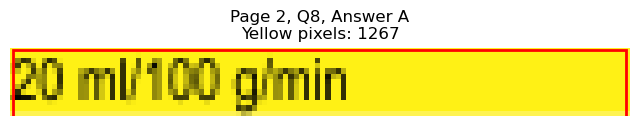

Page 2, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=130.0, y1=594.4
Page 2, Q8, B: Yellow pixels: 110
Page 2, Q8, B: Total non-white pixels: 379
Page 2, Q8, B: Yellow percentage: 29.0%


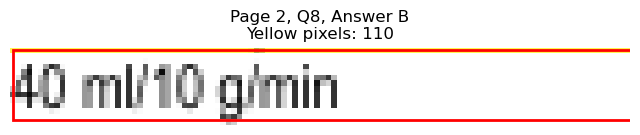

Page 2, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=394.3, y1=581.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 335
Page 2, Q8, C: Yellow percentage: 0.0%


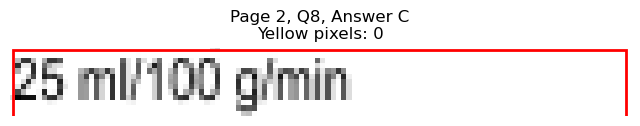

Page 2, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=394.3, y1=594.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 338
Page 2, Q8, D: Yellow percentage: 0.0%


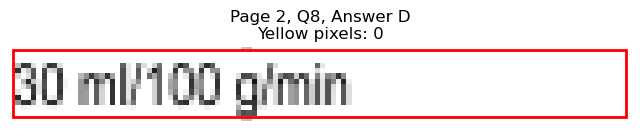


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=118.0, y1=644.9
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 363
Page 2, Q9, A: Yellow percentage: 0.0%


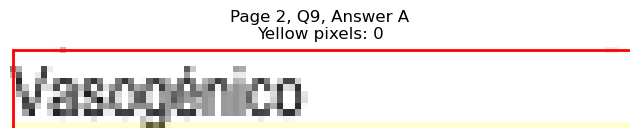

Page 2, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=111.4, y1=657.5
Page 2, Q9, B: Yellow pixels: 1041
Page 2, Q9, B: Total non-white pixels: 1316
Page 2, Q9, B: Yellow percentage: 79.1%


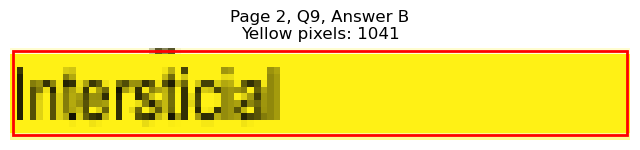

Page 2, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=369.7, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 222
Page 2, Q9, C: Yellow percentage: 0.0%


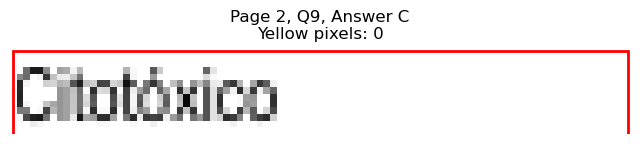

Page 2, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=377.2, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 264
Page 2, Q9, D: Yellow percentage: 0.0%


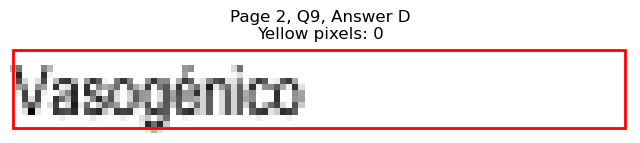


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=156.6, y1=720.6
Page 2, Q10, A: Yellow pixels: 1463
Page 2, Q10, A: Total non-white pixels: 1946
Page 2, Q10, A: Yellow percentage: 75.2%


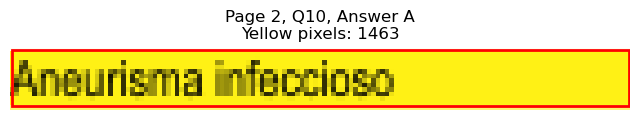

Page 2, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=179.2, y1=733.2
Page 2, Q10, B: Yellow pixels: 162
Page 2, Q10, B: Total non-white pixels: 705
Page 2, Q10, B: Yellow percentage: 23.0%


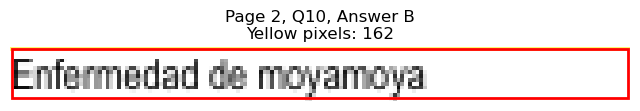

Page 2, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=417.3, y1=720.6
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 495
Page 2, Q10, C: Yellow percentage: 0.0%


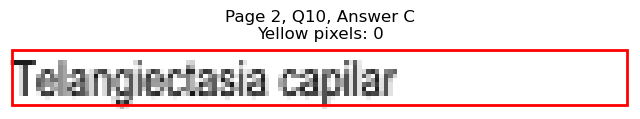

Page 2, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=414.3, y1=733.2
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 442
Page 2, Q10, D: Yellow percentage: 0.0%


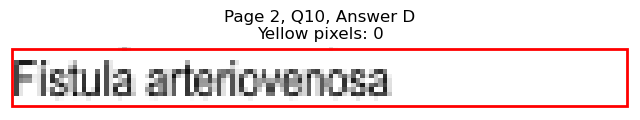


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 12 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=229.8, y1=102.1
Page 3, Q1, A: Yellow pixels: 212
Page 3, Q1, A: Total non-white pixels: 1001
Page 3, Q1, A: Yellow percentage: 21.2%


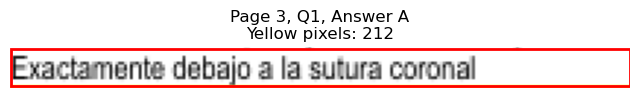

Page 3, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=239.3, y1=114.7
Page 3, Q1, B: Yellow pixels: 2111
Page 3, Q1, B: Total non-white pixels: 2782
Page 3, Q1, B: Yellow percentage: 75.9%


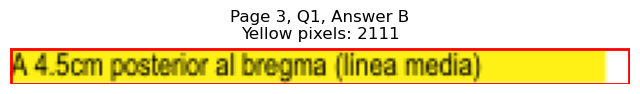

Page 3, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=449.9, y1=102.1
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 568
Page 3, Q1, C: Yellow percentage: 0.0%


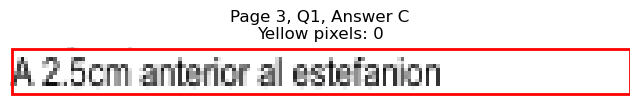

Page 3, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=428.3, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 475
Page 3, Q1, D: Yellow percentage: 0.0%


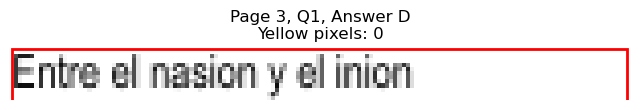


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=284.9, y1=165.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 1017
Page 3, Q2, A: Yellow percentage: 0.0%


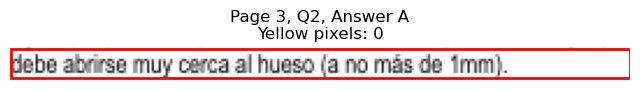

Page 3, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=237.8, y1=177.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 770
Page 3, Q2, B: Yellow percentage: 0.0%


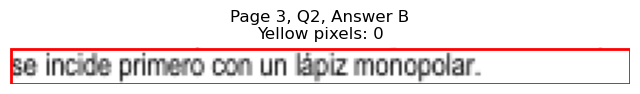

Page 3, Q2 - C: Detected box: x0=68.8, y0=177.7, x1=278.4, y1=190.4
Page 3, Q2, C: Yellow pixels: 261
Page 3, Q2, C: Total non-white pixels: 1265
Page 3, Q2, C: Yellow percentage: 20.6%


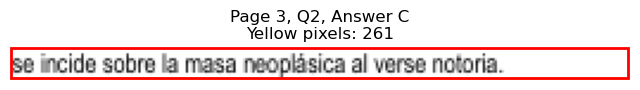

Page 3, Q2 - D: Detected box: x0=68.8, y0=190.3, x1=316.6, y1=203.0
Page 3, Q2, D: Yellow pixels: 2989
Page 3, Q2, D: Total non-white pixels: 3887
Page 3, Q2, D: Yellow percentage: 76.9%


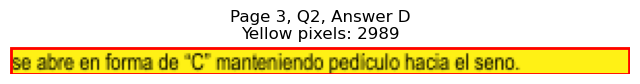


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=153.0, y1=240.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 429
Page 3, Q3, A: Yellow percentage: 0.0%


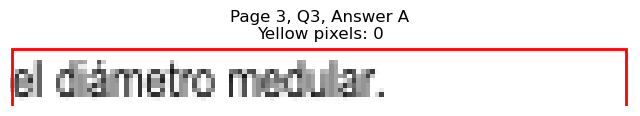

Page 3, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=178.7, y1=253.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 519
Page 3, Q3, B: Yellow percentage: 0.0%


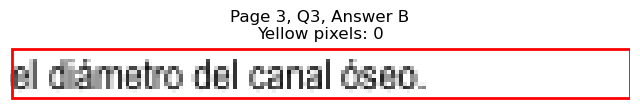

Page 3, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=392.7, y1=240.9
Page 3, Q3, C: Yellow pixels: 1284
Page 3, Q3, C: Total non-white pixels: 1508
Page 3, Q3, C: Yellow percentage: 85.1%


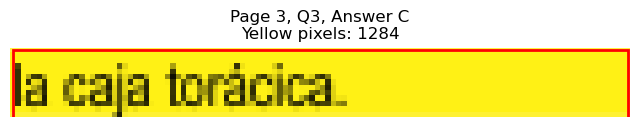

Page 3, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=419.8, y1=253.5
Page 3, Q3, D: Yellow pixels: 141
Page 3, Q3, D: Total non-white pixels: 606
Page 3, Q3, D: Yellow percentage: 23.3%


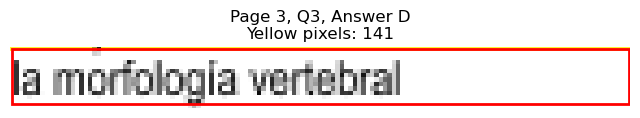


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=182.2, y1=291.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 592
Page 3, Q4, A: Yellow percentage: 0.0%


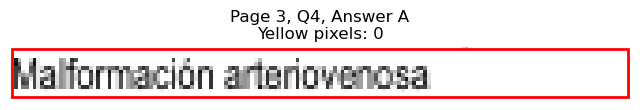

Page 3, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=214.2, y1=304.1
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 693
Page 3, Q4, B: Yellow percentage: 0.0%


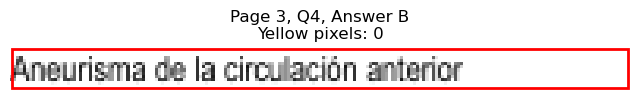

Page 3, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=446.5, y1=291.5
Page 3, Q4, C: Yellow pixels: 170
Page 3, Q4, C: Total non-white pixels: 791
Page 3, Q4, C: Yellow percentage: 21.5%


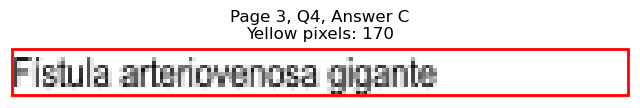

Page 3, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=409.7, y1=304.1
Page 3, Q4, D: Yellow pixels: 1429
Page 3, Q4, D: Total non-white pixels: 1862
Page 3, Q4, D: Yellow percentage: 76.7%


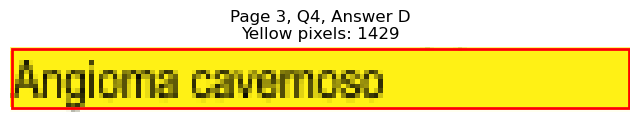


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=99.9, y1=341.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 177
Page 3, Q5, A: Yellow percentage: 0.0%


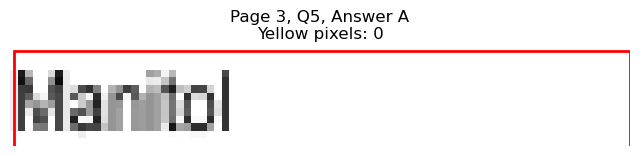

Page 3, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=178.1, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 564
Page 3, Q5, B: Yellow percentage: 0.0%


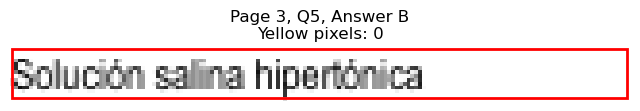

Page 3, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=372.7, y1=341.9
Page 3, Q5, C: Yellow pixels: 1076
Page 3, Q5, C: Total non-white pixels: 1248
Page 3, Q5, C: Yellow percentage: 86.2%


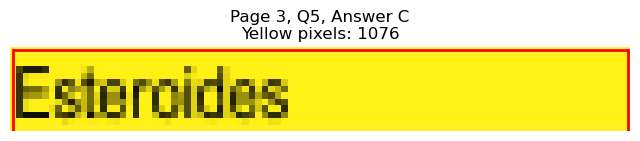

Page 3, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=392.2, y1=354.6
Page 3, Q5, D: Yellow pixels: 116
Page 3, Q5, D: Total non-white pixels: 439
Page 3, Q5, D: Yellow percentage: 26.4%


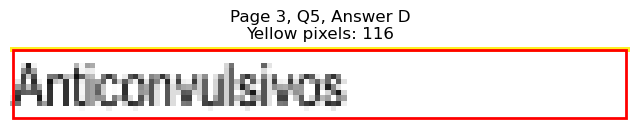


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=153.0, y1=392.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 425
Page 3, Q6, A: Yellow percentage: 0.0%


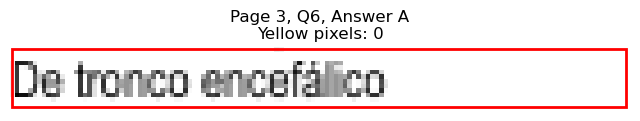

Page 3, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=119.4, y1=405.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 257
Page 3, Q6, B: Yellow percentage: 0.0%


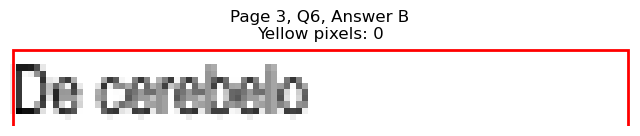

Page 3, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=398.8, y1=392.4
Page 3, Q6, C: Yellow pixels: 122
Page 3, Q6, C: Total non-white pixels: 483
Page 3, Q6, C: Yellow percentage: 25.3%


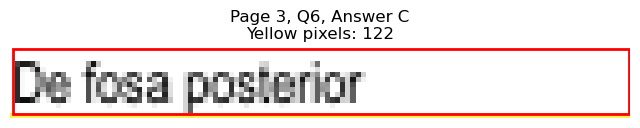

Page 3, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=395.7, y1=405.0
Page 3, Q6, D: Yellow pixels: 1285
Page 3, Q6, D: Total non-white pixels: 1547
Page 3, Q6, D: Yellow percentage: 83.1%


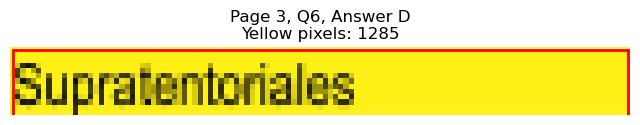


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=118.9, y1=442.9
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 234
Page 3, Q7, A: Yellow percentage: 0.0%


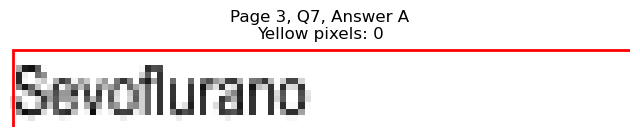

Page 3, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=114.5, y1=455.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 243
Page 3, Q7, B: Yellow percentage: 0.0%


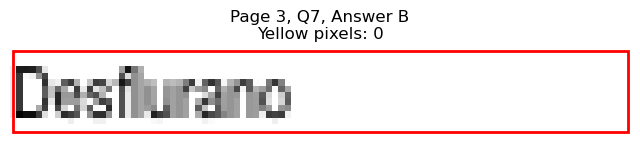

Page 3, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=368.2, y1=442.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 306
Page 3, Q7, C: Yellow percentage: 0.0%


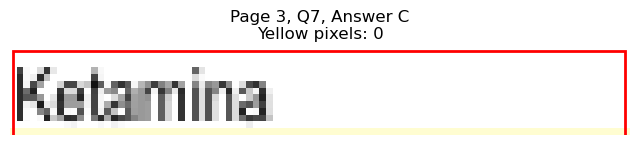

Page 3, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=363.7, y1=455.5
Page 3, Q7, D: Yellow pixels: 993
Page 3, Q7, D: Total non-white pixels: 1218
Page 3, Q7, D: Yellow percentage: 81.5%


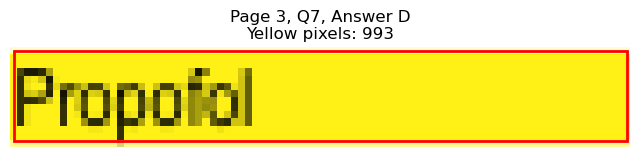


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=192.1, y1=493.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 593
Page 3, Q8, A: Yellow percentage: 0.0%


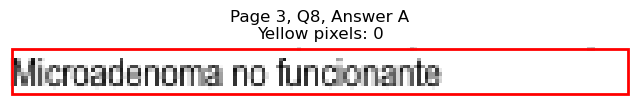

Page 3, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=195.3, y1=506.0
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 600
Page 3, Q8, B: Yellow percentage: 0.0%


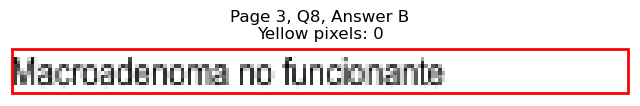

Page 3, Q8 - C: Detected box: x0=327.5, y0=480.8, x1=417.8, y1=493.4
Page 3, Q8, C: Yellow pixels: 1348
Page 3, Q8, C: Total non-white pixels: 1974
Page 3, Q8, C: Yellow percentage: 68.3%


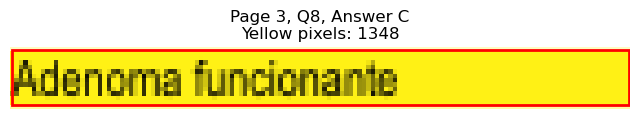

Page 3, Q8 - D: Detected box: x0=327.5, y0=493.4, x1=491.1, y1=506.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 982
Page 3, Q8, D: Yellow percentage: 0.0%


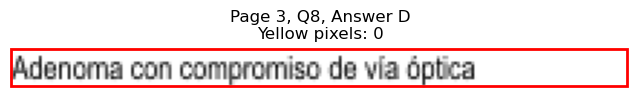


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=531.2, x1=407.9, y1=543.8
Page 3, Q9, A: Yellow pixels: 3781
Page 3, Q9, A: Total non-white pixels: 5070
Page 3, Q9, A: Yellow percentage: 74.6%


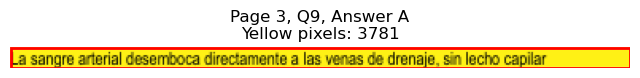

Page 3, Q9 - B: Detected box: x0=68.3, y0=543.8, x1=410.9, y1=556.4
Page 3, Q9, B: Yellow pixels: 385
Page 3, Q9, B: Total non-white pixels: 2028
Page 3, Q9, B: Yellow percentage: 19.0%


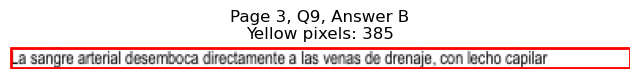

Page 3, Q9 - C: Detected box: x0=68.8, y0=556.5, x1=281.9, y1=569.2
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 1073
Page 3, Q9, C: Yellow percentage: 0.0%


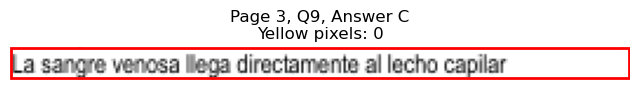

Page 3, Q9 - D: Detected box: x0=68.8, y0=569.1, x1=280.4, y1=581.8
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 1091
Page 3, Q9, D: Yellow percentage: 0.0%


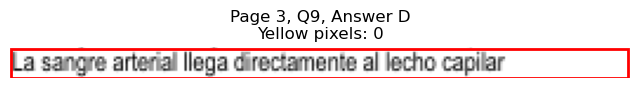


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=142.6, y1=619.6
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 336
Page 3, Q10, A: Yellow percentage: 0.0%


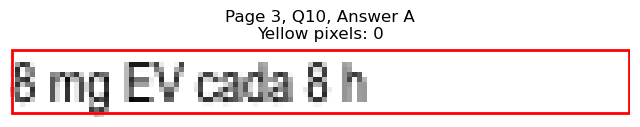

Page 3, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=216.3, y1=632.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 675
Page 3, Q10, B: Yellow percentage: 0.0%


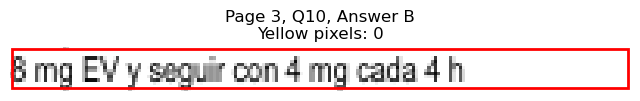

Page 3, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=387.2, y1=619.6
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 278
Page 3, Q10, C: Yellow percentage: 0.0%


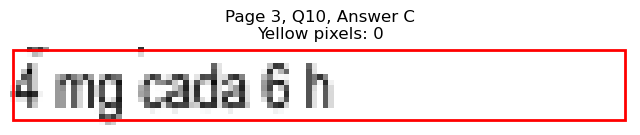

Page 3, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=406.3, y1=632.3
Page 3, Q10, D: Yellow pixels: 1275
Page 3, Q10, D: Total non-white pixels: 1820
Page 3, Q10, D: Yellow percentage: 70.1%


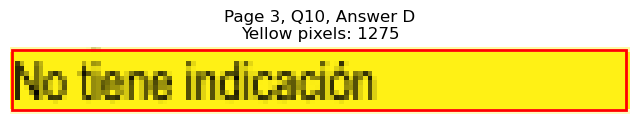


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=399.3, y1=670.1
Page 3, Q11, A: Yellow pixels: 3627
Page 3, Q11, A: Total non-white pixels: 5348
Page 3, Q11, A: Yellow percentage: 67.8%


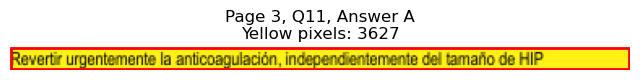

Page 3, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=383.8, y1=682.7
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 1859
Page 3, Q11, B: Yellow percentage: 0.0%


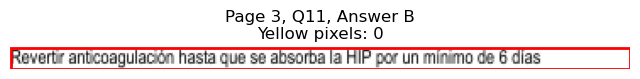

Page 3, Q11 - C: Detected box: x0=68.8, y0=682.7, x1=229.2, y1=695.3
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 801
Page 3, Q11, C: Yellow percentage: 0.0%


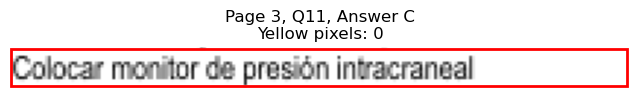

Page 3, Q11 - D: Detected box: x0=68.8, y0=695.4, x1=274.5, y1=708.0
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 1003
Page 3, Q11, D: Yellow percentage: 0.0%


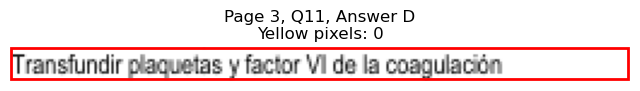


Page 3, Q11 - Selected Answer: A (based on yellow pixel count)




Page 3, Q12 - A: Detected box: x0=68.3, y0=329.2, x1=99.9, y1=341.9
Page 3, Q12, A: Yellow pixels: 0
Page 3, Q12, A: Total non-white pixels: 177
Page 3, Q12, A: Yellow percentage: 0.0%


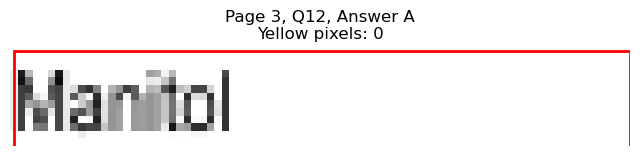

Page 3, Q12 - B: Detected box: x0=68.3, y0=745.8, x1=171.1, y1=758.4
Page 3, Q12, B: Yellow pixels: 0
Page 3, Q12, B: Total non-white pixels: 541
Page 3, Q12, B: Yellow percentage: 0.0%


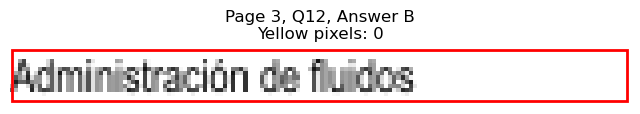

Page 3, Q12 - C: Detected box: x0=327.5, y0=733.2, x1=399.3, y1=745.8
Page 3, Q12, C: Yellow pixels: 0
Page 3, Q12, C: Total non-white pixels: 499
Page 3, Q12, C: Yellow percentage: 0.0%


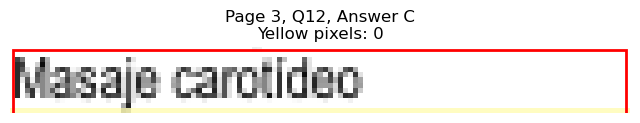

Page 3, Q12 - D: Detected box: x0=327.5, y0=745.8, x1=536.3, y1=758.4
Page 3, Q12, D: Yellow pixels: 1967
Page 3, Q12, D: Total non-white pixels: 2996
Page 3, Q12, D: Yellow percentage: 65.7%


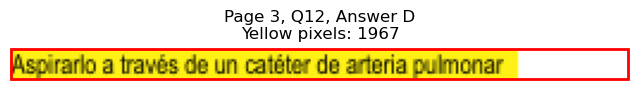


Page 3, Q12 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=79.3, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 38
Page 4, Q1, A: Yellow percentage: 0.0%


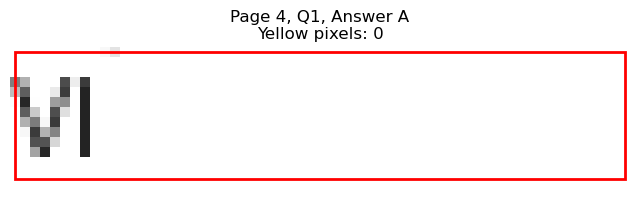

Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=79.3, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 36
Page 4, Q1, B: Yellow percentage: 0.0%


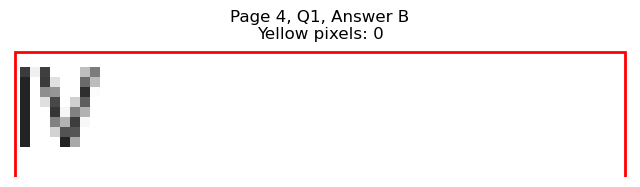

Page 4, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=337.6, y1=102.1
Page 4, Q1, C: Yellow pixels: 753
Page 4, Q1, C: Total non-white pixels: 854
Page 4, Q1, C: Yellow percentage: 88.2%


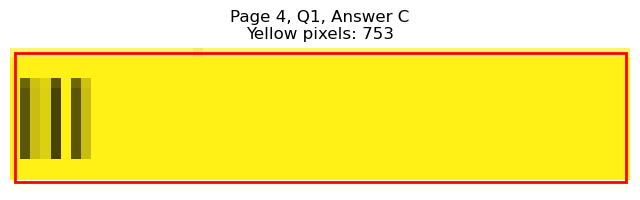

Page 4, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=324.4, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 132
Page 4, Q1, D: Yellow percentage: 0.0%


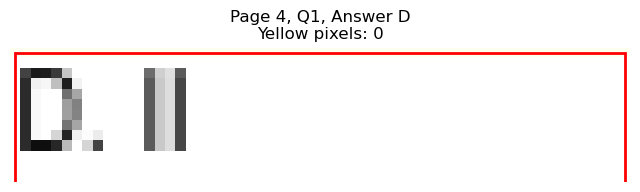


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=296.4, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 1400
Page 4, Q2, A: Yellow percentage: 0.0%


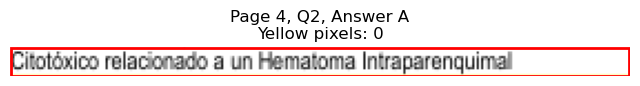

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=263.4, y1=190.4
Page 4, Q2, B: Yellow pixels: 2213
Page 4, Q2, B: Total non-white pixels: 3444
Page 4, Q2, B: Yellow percentage: 64.3%


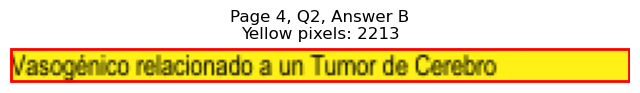

Page 4, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=316.5, y1=203.0
Page 4, Q2, C: Yellow pixels: 1
Page 4, Q2, C: Total non-white pixels: 1523
Page 4, Q2, C: Yellow percentage: 0.1%


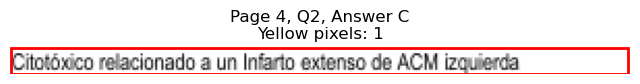

Page 4, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=309.0, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 1166
Page 4, Q2, D: Yellow percentage: 0.0%


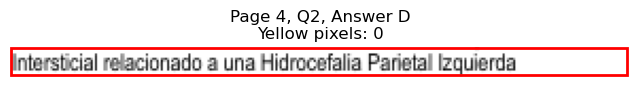


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=130.5, y1=253.5
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 303
Page 4, Q3, A: Yellow percentage: 0.0%


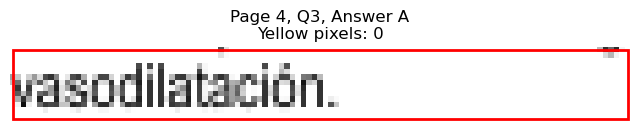

Page 4, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=153.5, y1=266.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 434
Page 4, Q3, B: Yellow percentage: 0.0%


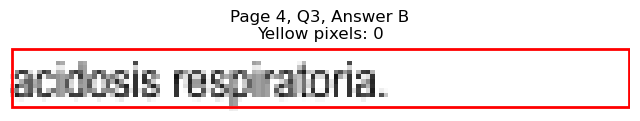

Page 4, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=399.3, y1=253.5
Page 4, Q3, C: Yellow pixels: 1320
Page 4, Q3, C: Total non-white pixels: 1722
Page 4, Q3, C: Yellow percentage: 76.7%


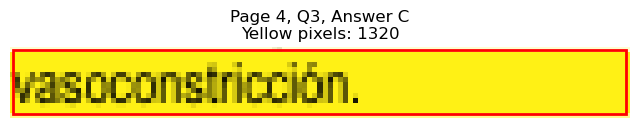

Page 4, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=382.3, y1=266.1
Page 4, Q3, D: Yellow pixels: 106
Page 4, Q3, D: Total non-white pixels: 365
Page 4, Q3, D: Yellow percentage: 29.0%


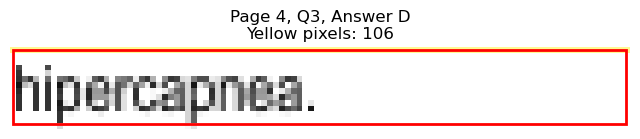


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=90.9, y1=316.7
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 154
Page 4, Q4, A: Yellow percentage: 0.0%


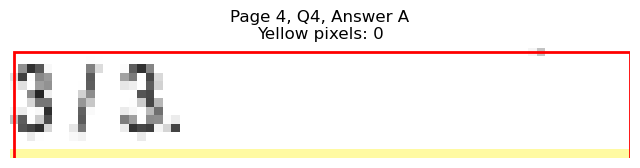

Page 4, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=90.9, y1=329.3
Page 4, Q4, B: Yellow pixels: 820
Page 4, Q4, B: Total non-white pixels: 1022
Page 4, Q4, B: Yellow percentage: 80.2%


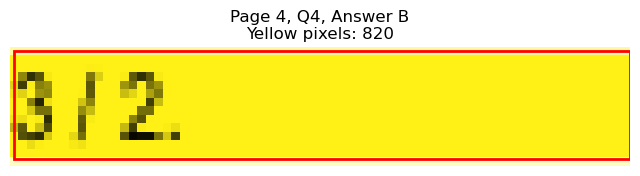

Page 4, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=350.1, y1=316.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 76
Page 4, Q4, C: Yellow percentage: 0.0%


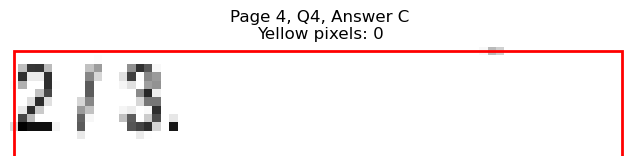

Page 4, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=350.1, y1=329.3
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 69
Page 4, Q4, D: Yellow percentage: 0.0%


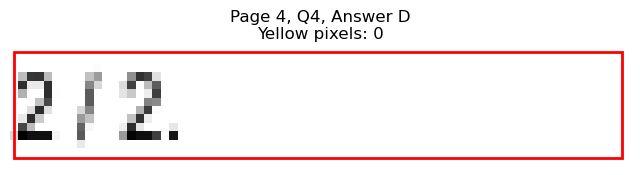


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=96.9, y1=367.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 136
Page 4, Q5, A: Yellow percentage: 0.0%


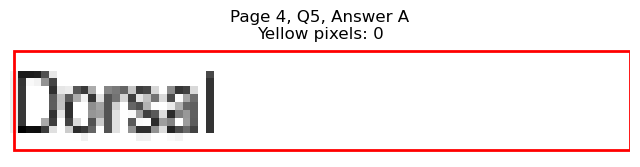

Page 4, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=103.3, y1=379.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 177
Page 4, Q5, B: Yellow percentage: 0.0%


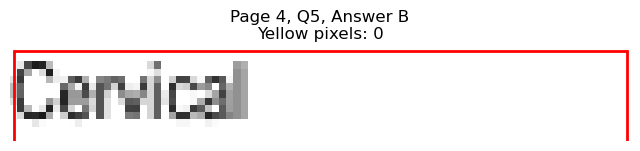

Page 4, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=380.2, y1=367.2
Page 4, Q5, C: Yellow pixels: 1166
Page 4, Q5, C: Total non-white pixels: 1456
Page 4, Q5, C: Yellow percentage: 80.1%


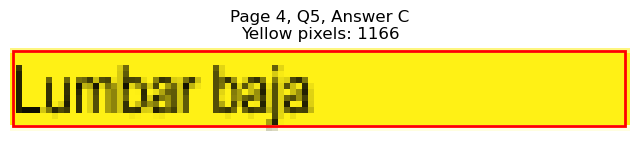

Page 4, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=381.7, y1=379.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 376
Page 4, Q5, D: Yellow percentage: 0.0%


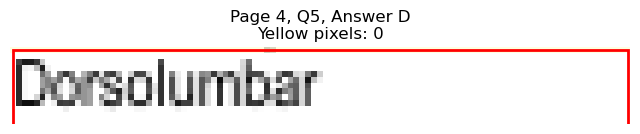


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=216.3, y1=417.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 749
Page 4, Q6, A: Yellow percentage: 0.0%


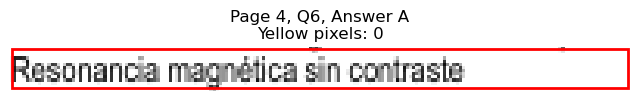

Page 4, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=173.7, y1=430.3
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 511
Page 4, Q6, B: Yellow percentage: 0.0%


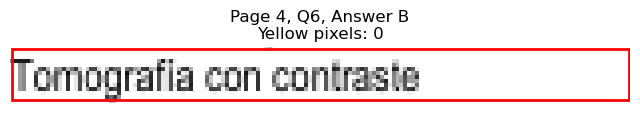

Page 4, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=478.5, y1=417.6
Page 4, Q6, C: Yellow pixels: 2060
Page 4, Q6, C: Total non-white pixels: 2828
Page 4, Q6, C: Yellow percentage: 72.8%


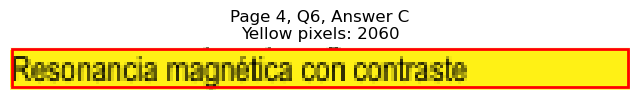

Page 4, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=374.7, y1=430.3
Page 4, Q6, D: Yellow pixels: 97
Page 4, Q6, D: Total non-white pixels: 364
Page 4, Q6, D: Yellow percentage: 26.6%


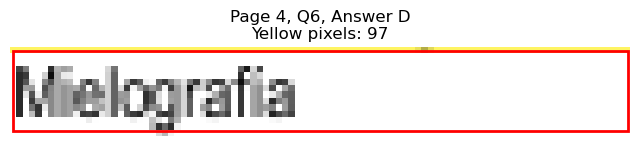


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=162.1, y1=468.1
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 492
Page 4, Q7, A: Yellow percentage: 0.0%


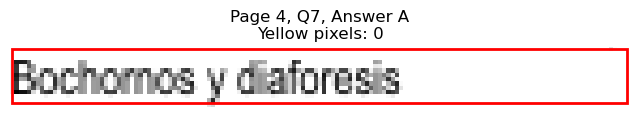

Page 4, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=124.5, y1=480.7
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 293
Page 4, Q7, B: Yellow percentage: 0.0%


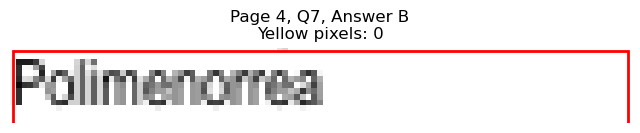

Page 4, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=462.5, y1=468.1
Page 4, Q7, C: Yellow pixels: 186
Page 4, Q7, C: Total non-white pixels: 860
Page 4, Q7, C: Yellow percentage: 21.6%


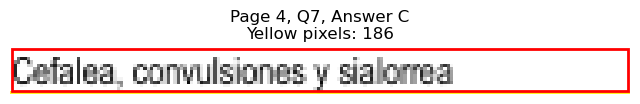

Page 4, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=476.0, y1=480.7
Page 4, Q7, D: Yellow pixels: 2010
Page 4, Q7, D: Total non-white pixels: 2600
Page 4, Q7, D: Yellow percentage: 77.3%


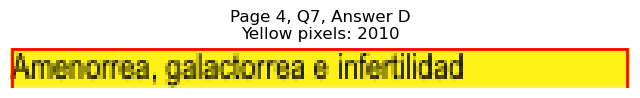


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=223.2, y1=531.2
Page 4, Q8, A: Yellow pixels: 206
Page 4, Q8, A: Total non-white pixels: 982
Page 4, Q8, A: Yellow percentage: 21.0%


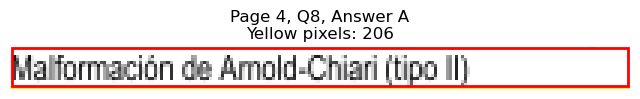

Page 4, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=198.3, y1=543.8
Page 4, Q8, B: Yellow pixels: 1856
Page 4, Q8, B: Total non-white pixels: 2353
Page 4, Q8, B: Yellow percentage: 78.9%


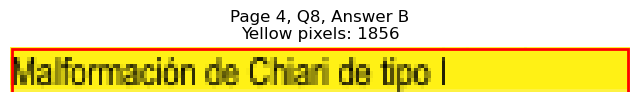

Page 4, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=456.4, y1=531.2
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 643
Page 4, Q8, C: Yellow percentage: 0.0%


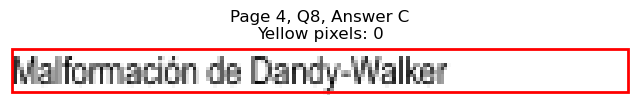

Page 4, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=414.3, y1=543.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 433
Page 4, Q8, D: Yellow percentage: 0.0%


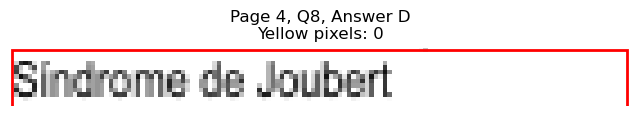


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=183.6, y1=594.4
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 591
Page 4, Q9, A: Yellow percentage: 0.0%


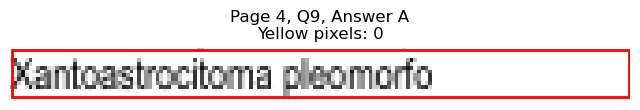

Page 4, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=164.1, y1=607.0
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 489
Page 4, Q9, B: Yellow percentage: 0.0%


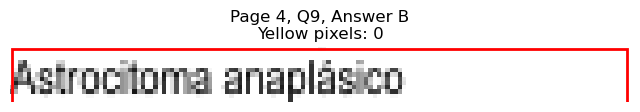

Page 4, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=448.9, y1=594.4
Page 4, Q9, C: Yellow pixels: 172
Page 4, Q9, C: Total non-white pixels: 789
Page 4, Q9, C: Yellow percentage: 21.8%


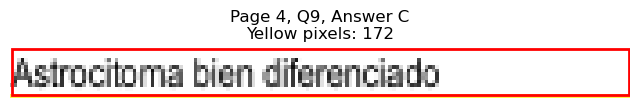

Page 4, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=443.3, y1=607.0
Page 4, Q9, D: Yellow pixels: 1731
Page 4, Q9, D: Total non-white pixels: 2171
Page 4, Q9, D: Yellow percentage: 79.7%


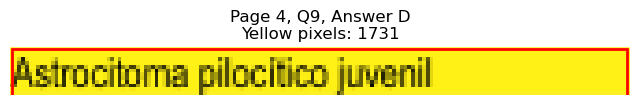


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=221.3, y1=644.9
Page 4, Q10, A: Yellow pixels: 2053
Page 4, Q10, A: Total non-white pixels: 2652
Page 4, Q10, A: Yellow percentage: 77.4%


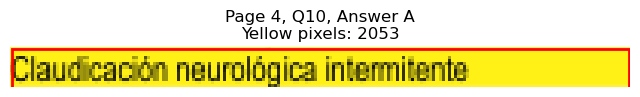

Page 4, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=209.7, y1=657.5
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 773
Page 4, Q10, B: Yellow percentage: 0.0%


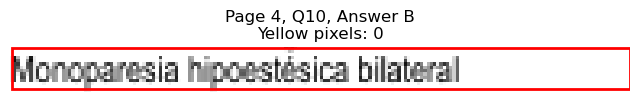

Page 4, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=474.9, y1=644.9
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 751
Page 4, Q10, C: Yellow percentage: 0.0%


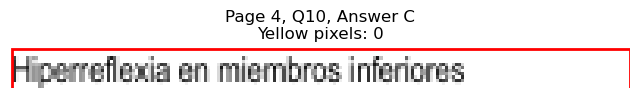

Page 4, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=455.9, y1=657.5
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 652
Page 4, Q10, D: Yellow percentage: 0.0%


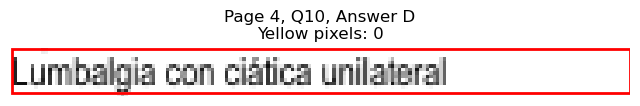


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=429.1, y1=708.0
Page 4, Q11, A: Yellow pixels: 3952
Page 4, Q11, A: Total non-white pixels: 5367
Page 4, Q11, A: Yellow percentage: 73.6%


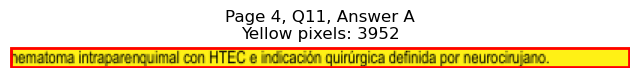

Page 4, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=305.6, y1=720.6
Page 4, Q11, B: Yellow pixels: 278
Page 4, Q11, B: Total non-white pixels: 1431
Page 4, Q11, B: Yellow percentage: 19.4%


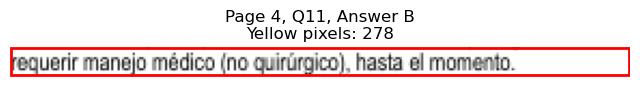

Page 4, Q11 - C: Detected box: x0=68.8, y0=720.6, x1=264.4, y1=733.2
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 954
Page 4, Q11, C: Yellow percentage: 0.0%


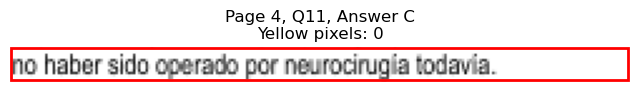

Page 4, Q11 - D: Detected box: x0=68.8, y0=733.2, x1=257.3, y1=745.8
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 931
Page 4, Q11, D: Yellow percentage: 0.0%


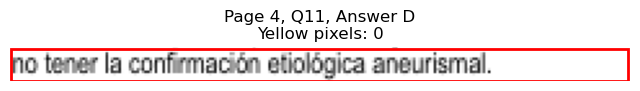


Page 4, Q11 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=105.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 196
Page 5, Q1, A: Yellow percentage: 0.0%


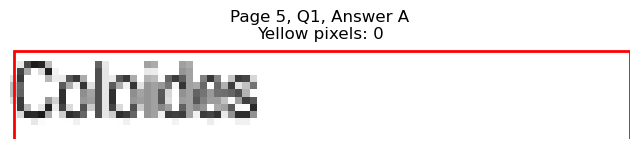

Page 5, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=118.6, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 251
Page 5, Q1, B: Yellow percentage: 0.0%


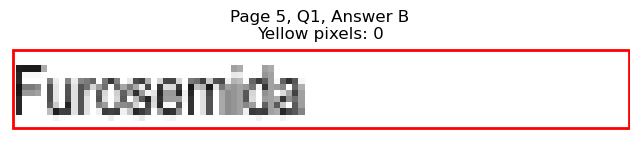

Page 5, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=420.8, y1=114.7
Page 5, Q1, C: Yellow pixels: 1519
Page 5, Q1, C: Total non-white pixels: 1872
Page 5, Q1, C: Yellow percentage: 81.1%


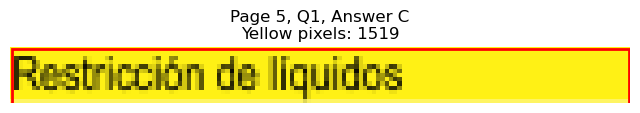

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=390.8, y1=127.3
Page 5, Q1, D: Yellow pixels: 114
Page 5, Q1, D: Total non-white pixels: 431
Page 5, Q1, D: Yellow percentage: 26.5%


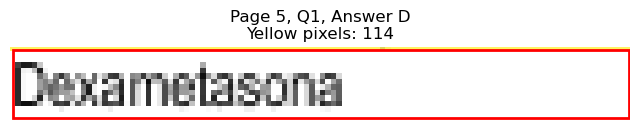


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=158.5, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 462
Page 5, Q2, A: Yellow percentage: 0.0%


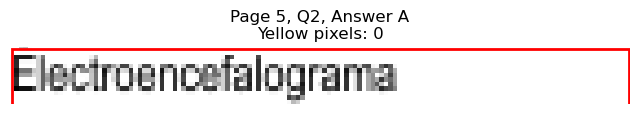

Page 5, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=194.2, y1=190.4
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 636
Page 5, Q2, B: Yellow percentage: 0.0%


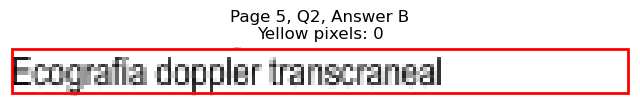

Page 5, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=530.7, y1=177.8
Page 5, Q2, C: Yellow pixels: 1
Page 5, Q2, C: Total non-white pixels: 1216
Page 5, Q2, C: Yellow percentage: 0.1%


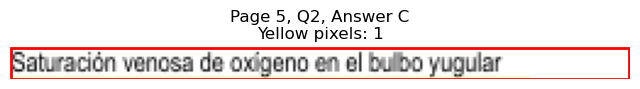

Page 5, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=404.2, y1=190.4
Page 5, Q2, D: Yellow pixels: 1239
Page 5, Q2, D: Total non-white pixels: 1792
Page 5, Q2, D: Yellow percentage: 69.1%


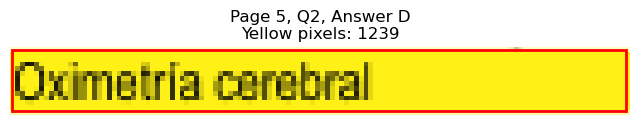


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=56.6, y0=215.7, x1=65.2, y1=228.3
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 73
Page 5, Q3, A: Yellow percentage: 0.0%


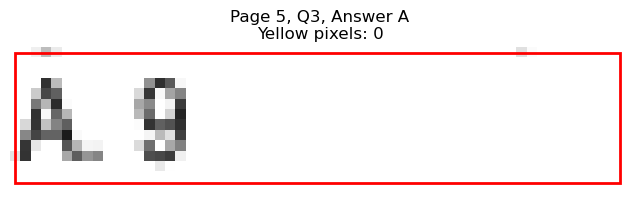

Page 5, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=80.9, y1=240.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 51
Page 5, Q3, B: Yellow percentage: 0.0%


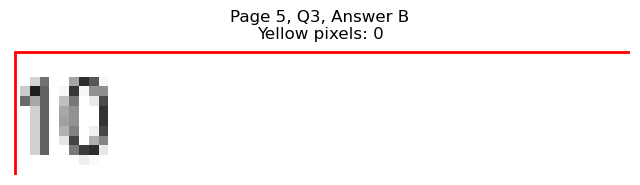

Page 5, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=340.1, y1=228.3
Page 5, Q3, C: Yellow pixels: 64
Page 5, Q3, C: Total non-white pixels: 91
Page 5, Q3, C: Yellow percentage: 70.3%


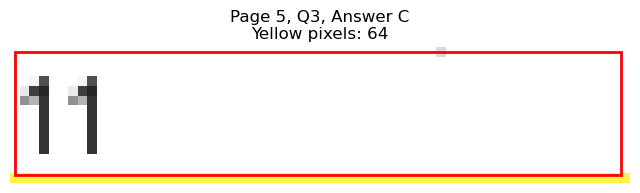

Page 5, Q3 - D: Detected box: x0=315.4, y0=228.3, x1=324.4, y1=240.9
Page 5, Q3, D: Yellow pixels: 726
Page 5, Q3, D: Total non-white pixels: 780
Page 5, Q3, D: Yellow percentage: 93.1%


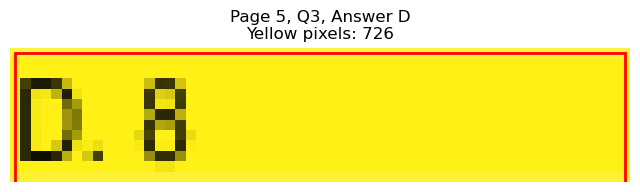


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=160.6, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 453
Page 5, Q4, A: Yellow percentage: 0.0%


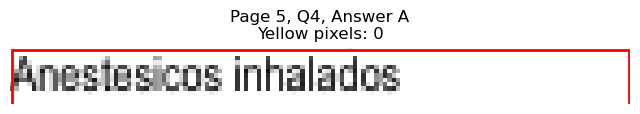

Page 5, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=117.4, y1=291.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 263
Page 5, Q4, B: Yellow percentage: 0.0%


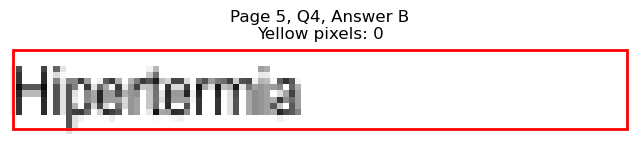

Page 5, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=437.3, y1=278.7
Page 5, Q4, C: Yellow pixels: 1658
Page 5, Q4, C: Total non-white pixels: 2093
Page 5, Q4, C: Yellow percentage: 79.2%


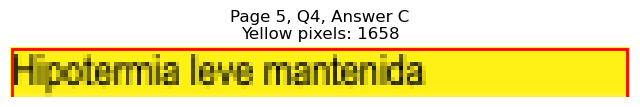

Page 5, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=421.3, y1=291.5
Page 5, Q4, D: Yellow pixels: 145
Page 5, Q4, D: Total non-white pixels: 639
Page 5, Q4, D: Yellow percentage: 22.7%


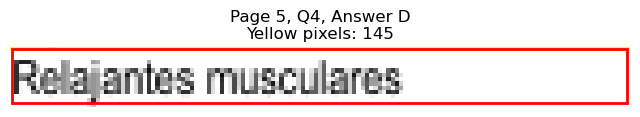


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=109.0, y1=329.3
Page 5, Q5, A: Yellow pixels: 939
Page 5, Q5, A: Total non-white pixels: 1274
Page 5, Q5, A: Yellow percentage: 73.7%


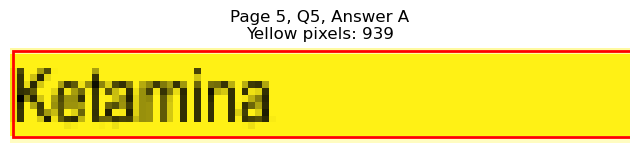

Page 5, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=104.4, y1=341.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 278
Page 5, Q5, B: Yellow percentage: 0.0%


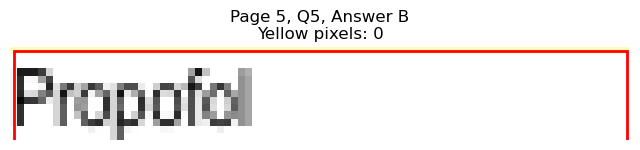

Page 5, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=398.9, y1=329.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 380
Page 5, Q5, C: Yellow percentage: 0.0%


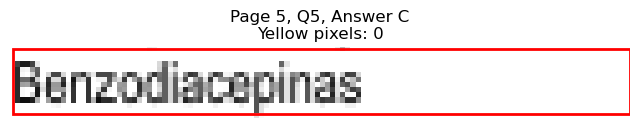

Page 5, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=377.7, y1=341.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 253
Page 5, Q5, D: Yellow percentage: 0.0%


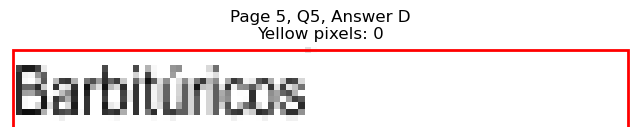


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=119.9, y1=405.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 289
Page 5, Q6, A: Yellow percentage: 0.0%


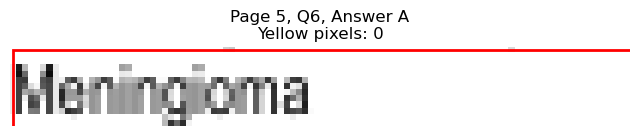

Page 5, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=128.5, y1=417.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 303
Page 5, Q6, B: Yellow percentage: 0.0%


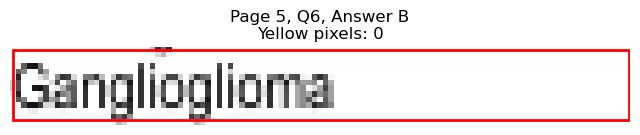

Page 5, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=396.3, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 500
Page 5, Q6, C: Yellow percentage: 0.0%


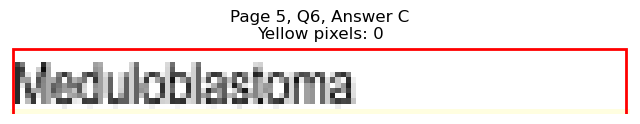

Page 5, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=405.8, y1=417.6
Page 5, Q6, D: Yellow pixels: 1385
Page 5, Q6, D: Total non-white pixels: 1806
Page 5, Q6, D: Yellow percentage: 76.7%


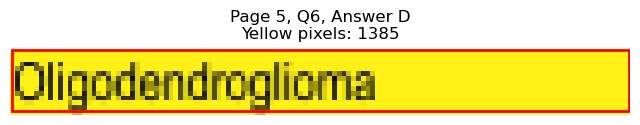


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=264.3, y1=480.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 999
Page 5, Q7, A: Yellow percentage: 0.0%


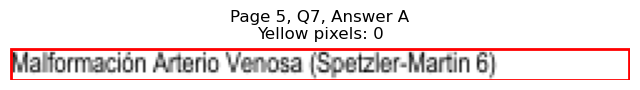

Page 5, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=264.3, y1=493.4
Page 5, Q7, B: Yellow pixels: 12
Page 5, Q7, B: Total non-white pixels: 1028
Page 5, Q7, B: Yellow percentage: 1.2%


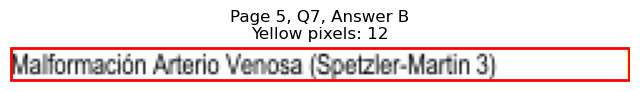

Page 5, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=443.2, y1=480.7
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 537
Page 5, Q7, C: Yellow percentage: 0.0%


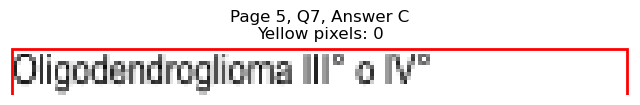

Page 5, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=523.5, y1=493.4
Page 5, Q7, D: Yellow pixels: 1787
Page 5, Q7, D: Total non-white pixels: 2996
Page 5, Q7, D: Yellow percentage: 59.6%


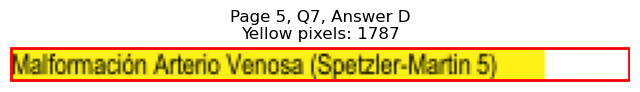


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=287.1, y1=569.2
Page 5, Q8, A: Yellow pixels: 270
Page 5, Q8, A: Total non-white pixels: 1366
Page 5, Q8, A: Yellow percentage: 19.8%


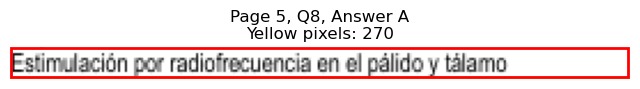

Page 5, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=355.3, y1=581.8
Page 5, Q8, B: Yellow pixels: 3265
Page 5, Q8, B: Total non-white pixels: 4394
Page 5, Q8, B: Yellow percentage: 74.3%


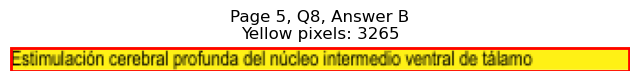

Page 5, Q8 - C: Detected box: x0=68.8, y0=581.7, x1=280.5, y1=594.4
Page 5, Q8, C: Yellow pixels: 263
Page 5, Q8, C: Total non-white pixels: 1340
Page 5, Q8, C: Yellow percentage: 19.6%


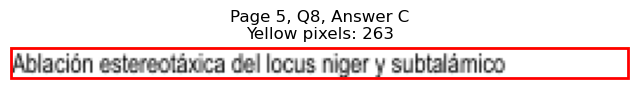

Page 5, Q8 - D: Detected box: x0=68.8, y0=594.3, x1=188.2, y1=607.0
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 600
Page 5, Q8, D: Yellow percentage: 0.0%


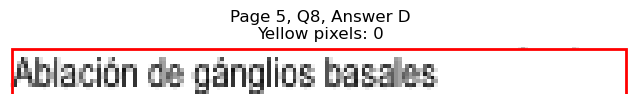


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=238.4, y1=657.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 856
Page 5, Q9, A: Yellow percentage: 0.0%


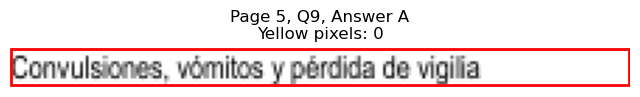

Page 5, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=162.1, y1=670.1
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 480
Page 5, Q9, B: Yellow percentage: 0.0%


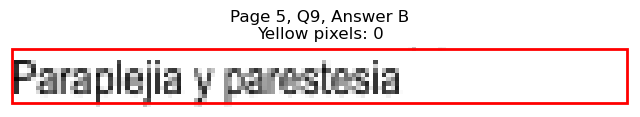

Page 5, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=483.6, y1=657.5
Page 5, Q9, C: Yellow pixels: 2081
Page 5, Q9, C: Total non-white pixels: 2898
Page 5, Q9, C: Yellow percentage: 71.8%


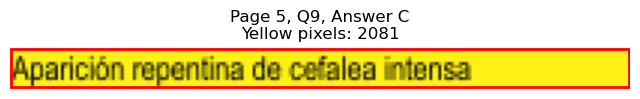

Page 5, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=427.4, y1=670.1
Page 5, Q9, D: Yellow pixels: 151
Page 5, Q9, D: Total non-white pixels: 669
Page 5, Q9, D: Yellow percentage: 22.6%


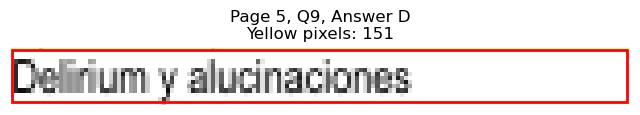


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=65.2, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 46
Page 5, Q10, A: Yellow percentage: 0.0%


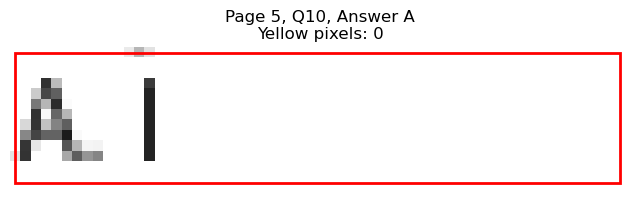

Page 5, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=65.2, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 66
Page 5, Q10, B: Yellow percentage: 0.0%


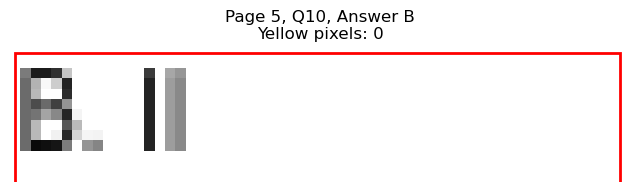

Page 5, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=338.6, y1=733.2
Page 5, Q10, C: Yellow pixels: 62
Page 5, Q10, C: Total non-white pixels: 104
Page 5, Q10, C: Yellow percentage: 59.6%


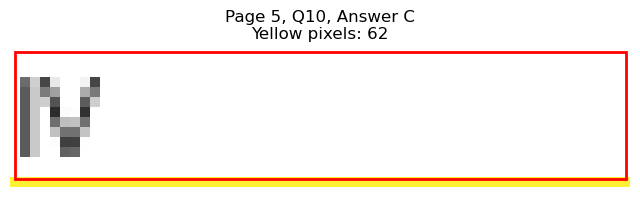

Page 5, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=324.4, y1=745.8
Page 5, Q10, D: Yellow pixels: 710
Page 5, Q10, D: Total non-white pixels: 780
Page 5, Q10, D: Yellow percentage: 91.0%


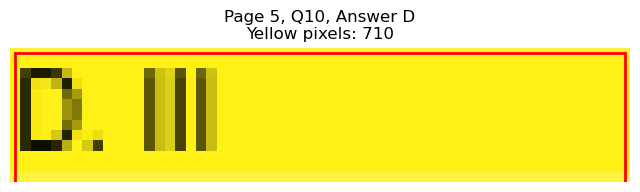


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=126.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 109
Page 6, Q1, A: Total non-white pixels: 399
Page 6, Q1, A: Yellow percentage: 27.3%


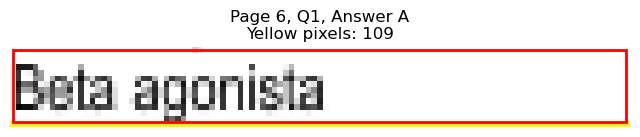

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=130.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 1214
Page 6, Q1, B: Total non-white pixels: 1469
Page 6, Q1, B: Yellow percentage: 82.6%


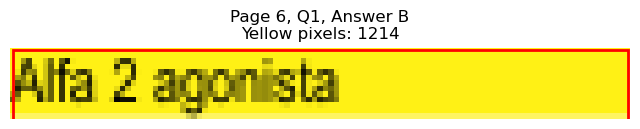

Page 6, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=386.7, y1=102.1
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 320
Page 6, Q1, C: Yellow percentage: 0.0%


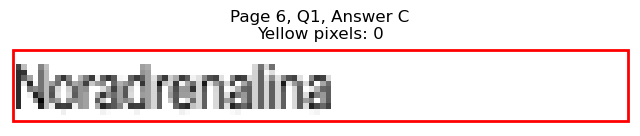

Page 6, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=373.1, y1=114.7
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 224
Page 6, Q1, D: Yellow percentage: 0.0%


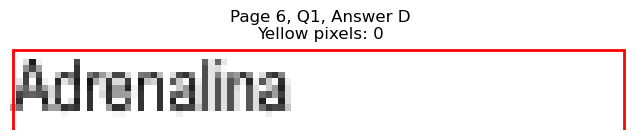


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=121.5, y1=177.8
Page 6, Q2, A: Yellow pixels: 1112
Page 6, Q2, A: Total non-white pixels: 1352
Page 6, Q2, A: Yellow percentage: 82.2%


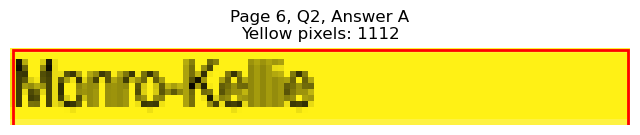

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=119.4, y1=190.4
Page 6, Q2, B: Yellow pixels: 102
Page 6, Q2, B: Total non-white pixels: 359
Page 6, Q2, B: Yellow percentage: 28.4%


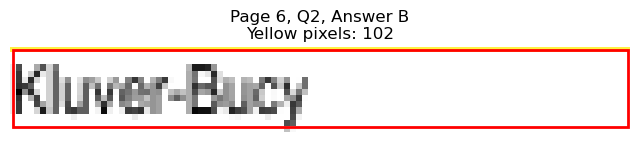

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=386.7, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 320
Page 6, Q2, C: Yellow percentage: 0.0%


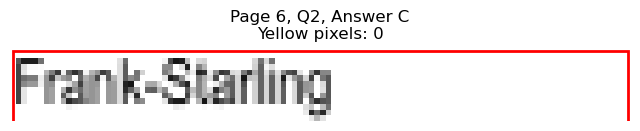

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=360.7, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 167
Page 6, Q2, D: Yellow percentage: 0.0%


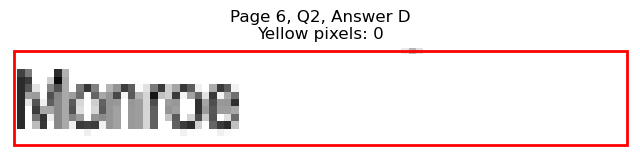


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=211.8, y1=240.9
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 699
Page 6, Q3, A: Yellow percentage: 0.0%


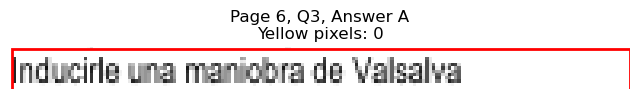

Page 6, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=184.6, y1=253.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 626
Page 6, Q3, B: Yellow percentage: 0.0%


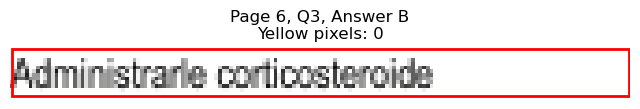

Page 6, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=421.9, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 632
Page 6, Q3, C: Yellow percentage: 0.0%


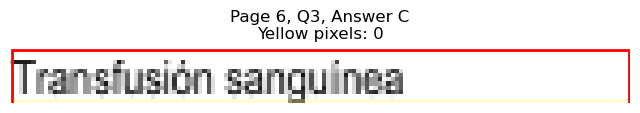

Page 6, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=541.2, y1=253.5
Page 6, Q3, D: Yellow pixels: 1946
Page 6, Q3, D: Total non-white pixels: 2996
Page 6, Q3, D: Yellow percentage: 65.0%


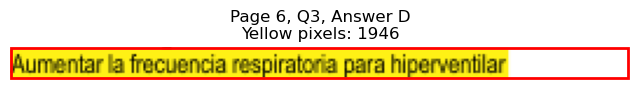


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=101.9, y1=304.1
Page 6, Q4, A: Yellow pixels: 983
Page 6, Q4, A: Total non-white pixels: 1176
Page 6, Q4, A: Yellow percentage: 83.6%


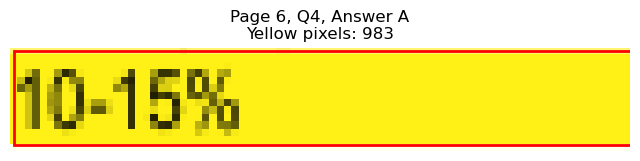

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=101.9, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 251
Page 6, Q4, B: Yellow percentage: 0.0%


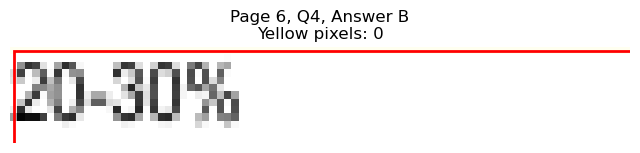

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=348.4, y1=304.1
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 96
Page 6, Q4, C: Yellow percentage: 0.0%


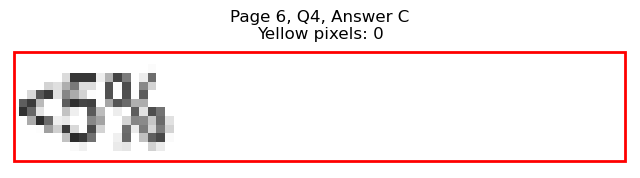

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=353.3, y1=316.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 125
Page 6, Q4, D: Yellow percentage: 0.0%


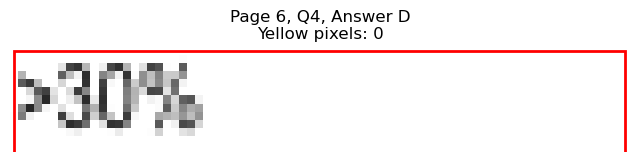


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=107.4, y1=354.6
Page 6, Q5, A: Yellow pixels: 996
Page 6, Q5, A: Total non-white pixels: 1260
Page 6, Q5, A: Yellow percentage: 79.0%


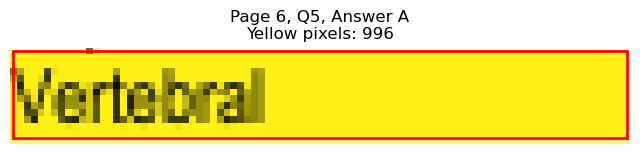

Page 6, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=98.4, y1=367.2
Page 6, Q5, B: Yellow pixels: 81
Page 6, Q5, B: Total non-white pixels: 251
Page 6, Q5, B: Yellow percentage: 32.3%


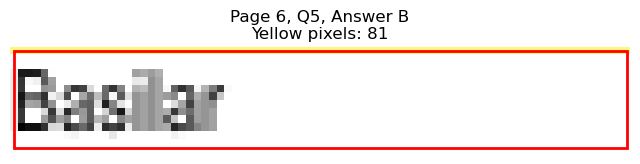

Page 6, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=376.1, y1=354.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 256
Page 6, Q5, C: Yellow percentage: 0.0%


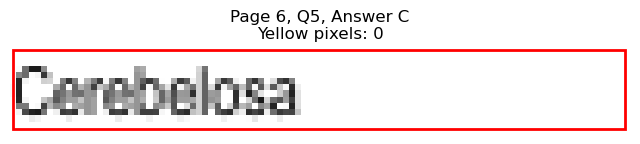

Page 6, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=394.3, y1=367.2
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 333
Page 6, Q5, D: Yellow percentage: 0.0%


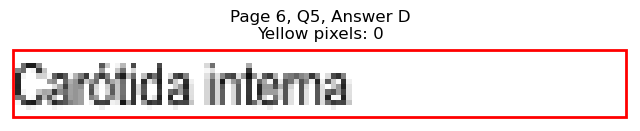


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=385.3, y1=442.9
Page 6, Q6, A: Yellow pixels: 3611
Page 6, Q6, A: Total non-white pixels: 4784
Page 6, Q6, A: Yellow percentage: 75.5%


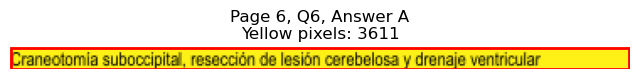

Page 6, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=171.1, y1=455.5
Page 6, Q6, B: Yellow pixels: 153
Page 6, Q6, B: Total non-white pixels: 681
Page 6, Q6, B: Yellow percentage: 22.5%


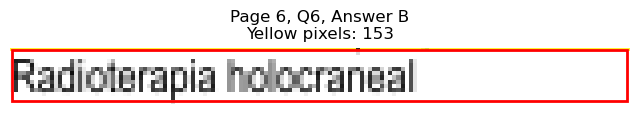

Page 6, Q6 - C: Detected box: x0=68.8, y0=455.5, x1=459.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 1931
Page 6, Q6, C: Yellow percentage: 0.0%


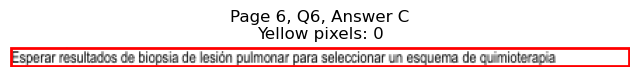

Page 6, Q6 - D: Detected box: x0=68.8, y0=468.1, x1=416.5, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 1743
Page 6, Q6, D: Yellow percentage: 0.0%


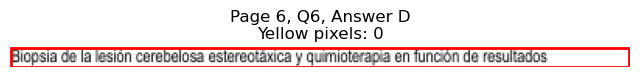


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=95.4, y1=531.2
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 130
Page 6, Q7, A: Yellow percentage: 0.0%


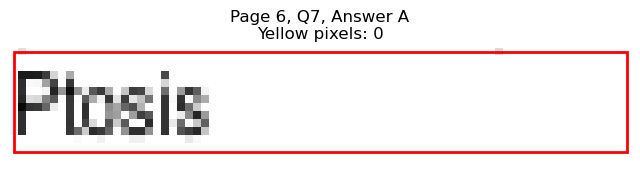

Page 6, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=112.0, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 223
Page 6, Q7, B: Yellow percentage: 0.0%


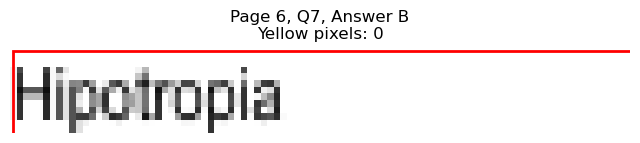

Page 6, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=365.7, y1=531.2
Page 6, Q7, C: Yellow pixels: 984
Page 6, Q7, C: Total non-white pixels: 1246
Page 6, Q7, C: Yellow percentage: 79.0%


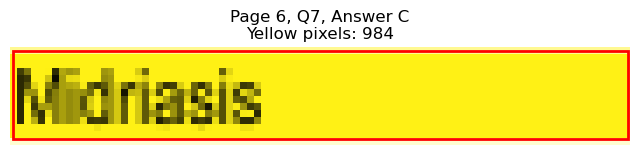

Page 6, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=368.2, y1=543.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 297
Page 6, Q7, D: Yellow percentage: 0.0%


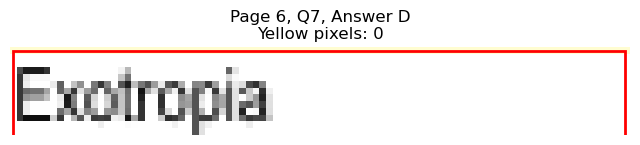


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=253.8, y1=581.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 937
Page 6, Q8, A: Yellow percentage: 0.0%


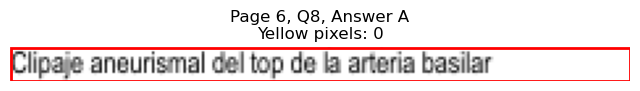

Page 6, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=220.7, y1=594.4
Page 6, Q8, B: Yellow pixels: 203
Page 6, Q8, B: Total non-white pixels: 986
Page 6, Q8, B: Yellow percentage: 20.6%


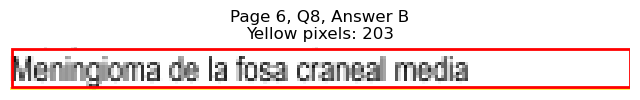

Page 6, Q8 - C: Detected box: x0=68.8, y0=594.3, x1=377.7, y1=607.0
Page 6, Q8, C: Yellow pixels: 3479
Page 6, Q8, C: Total non-white pixels: 4680
Page 6, Q8, C: Yellow percentage: 74.3%


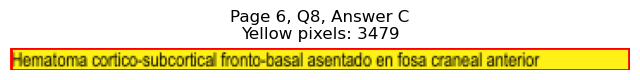

Page 6, Q8 - D: Detected box: x0=68.8, y0=606.9, x1=176.5, y1=619.6
Page 6, Q8, D: Yellow pixels: 159
Page 6, Q8, D: Total non-white pixels: 741
Page 6, Q8, D: Yellow percentage: 21.5%


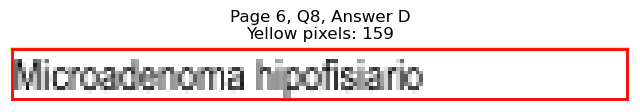


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=115.6, y1=657.5
Page 6, Q9, A: Yellow pixels: 98
Page 6, Q9, A: Total non-white pixels: 350
Page 6, Q9, A: Yellow percentage: 28.0%


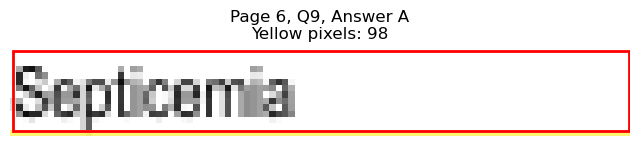

Page 6, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=197.8, y1=670.1
Page 6, Q9, B: Yellow pixels: 1832
Page 6, Q9, B: Total non-white pixels: 2520
Page 6, Q9, B: Yellow percentage: 72.7%


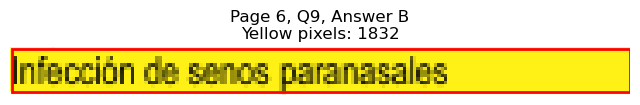

Page 6, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=379.1, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 261
Page 6, Q9, C: Yellow percentage: 0.0%


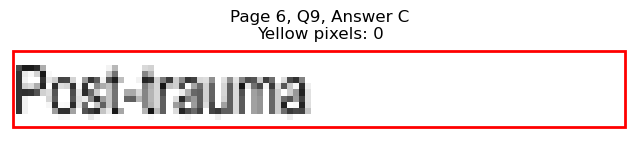

Page 6, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=378.2, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 257
Page 6, Q9, D: Yellow percentage: 0.0%


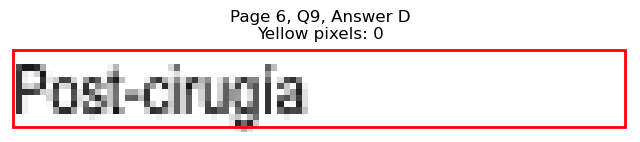


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=150.6, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 434
Page 6, Q10, A: Yellow percentage: 0.0%


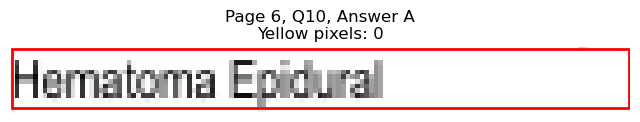

Page 6, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=264.4, y1=720.6
Page 6, Q10, B: Yellow pixels: 247
Page 6, Q10, B: Total non-white pixels: 1222
Page 6, Q10, B: Yellow percentage: 20.2%


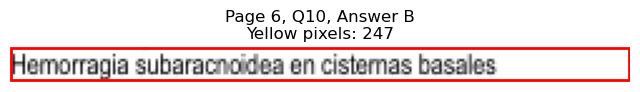

Page 6, Q10 - C: Detected box: x0=68.8, y0=720.6, x1=294.9, y1=733.2
Page 6, Q10, C: Yellow pixels: 2651
Page 6, Q10, C: Total non-white pixels: 3878
Page 6, Q10, C: Yellow percentage: 68.4%


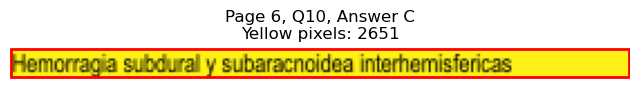

Page 6, Q10 - D: Detected box: x0=68.8, y0=733.2, x1=174.7, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 686
Page 6, Q10, D: Yellow percentage: 0.0%


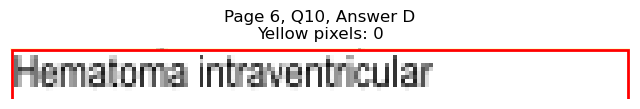


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=91.8, y1=102.1
Page 7, Q1, A: Yellow pixels: 878
Page 7, Q1, A: Total non-white pixels: 1036
Page 7, Q1, A: Yellow percentage: 84.7%


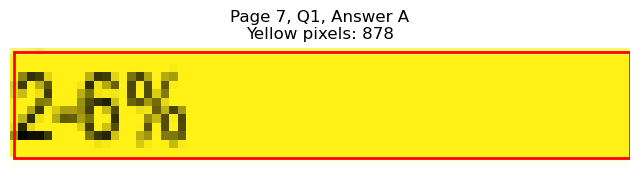

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=96.9, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 207
Page 7, Q1, B: Yellow percentage: 0.0%


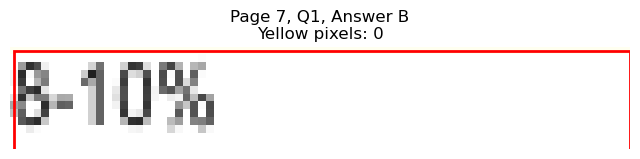

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=361.1, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 140
Page 7, Q1, C: Yellow percentage: 0.0%


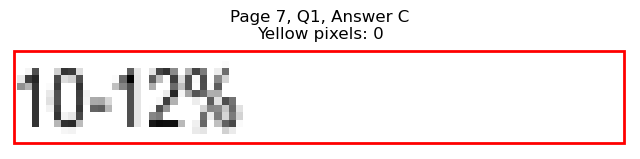

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=361.1, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 169
Page 7, Q1, D: Yellow percentage: 0.0%


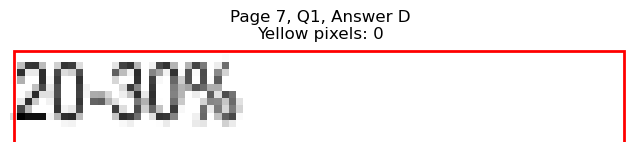


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=133.5, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 298
Page 7, Q2, A: Yellow percentage: 0.0%


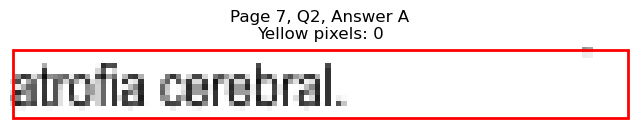

Page 7, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=125.5, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 280
Page 7, Q2, B: Yellow percentage: 0.0%


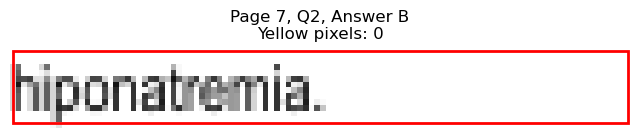

Page 7, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=420.3, y1=152.6
Page 7, Q2, C: Yellow pixels: 144
Page 7, Q2, C: Total non-white pixels: 613
Page 7, Q2, C: Yellow percentage: 23.5%


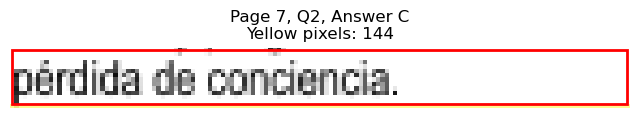

Page 7, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=390.8, y1=165.2
Page 7, Q2, D: Yellow pixels: 1249
Page 7, Q2, D: Total non-white pixels: 1596
Page 7, Q2, D: Yellow percentage: 78.3%


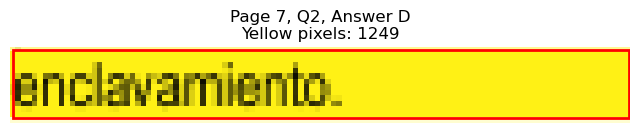


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=170.7, y1=203.0
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 451
Page 7, Q3, A: Yellow percentage: 0.0%


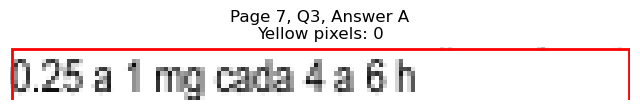

Page 7, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=120.5, y1=215.6
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 253
Page 7, Q3, B: Yellow percentage: 0.0%


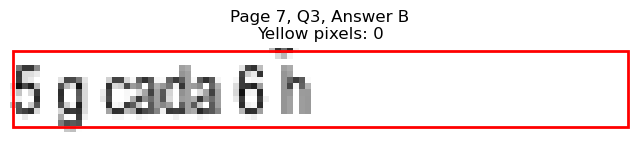

Page 7, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=422.3, y1=203.0
Page 7, Q3, C: Yellow pixels: 1608
Page 7, Q3, C: Total non-white pixels: 1898
Page 7, Q3, C: Yellow percentage: 84.7%


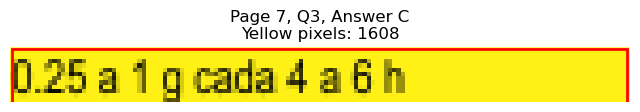

Page 7, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=397.3, y1=215.6
Page 7, Q3, D: Yellow pixels: 117
Page 7, Q3, D: Total non-white pixels: 441
Page 7, Q3, D: Yellow percentage: 26.5%


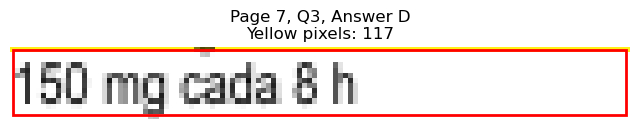


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=240.9, x1=275.4, y1=253.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 1002
Page 7, Q4, A: Yellow percentage: 0.0%


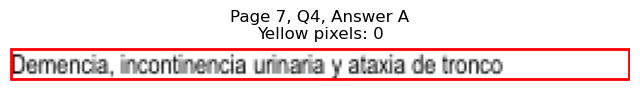

Page 7, Q4 - B: Detected box: x0=68.3, y0=253.5, x1=273.9, y1=266.1
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 1012
Page 7, Q4, B: Yellow percentage: 0.0%


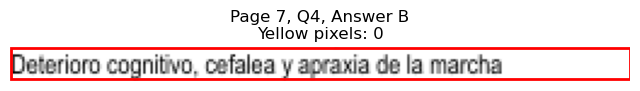

Page 7, Q4 - C: Detected box: x0=68.8, y0=266.1, x1=242.3, y1=278.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 835
Page 7, Q4, C: Yellow percentage: 0.0%


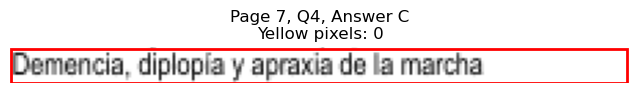

Page 7, Q4 - D: Detected box: x0=68.8, y0=278.8, x1=330.5, y1=291.5
Page 7, Q4, D: Yellow pixels: 3052
Page 7, Q4, D: Total non-white pixels: 4382
Page 7, Q4, D: Yellow percentage: 69.6%


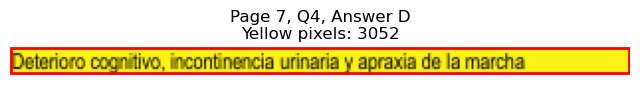


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=142.1, y1=329.3
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 342
Page 7, Q5, A: Yellow percentage: 0.0%


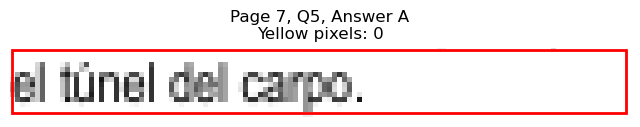

Page 7, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=189.7, y1=341.9
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 591
Page 7, Q5, B: Yellow percentage: 0.0%


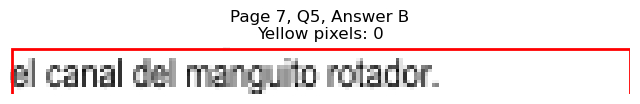

Page 7, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=494.6, y1=329.3
Page 7, Q5, C: Yellow pixels: 1933
Page 7, Q5, C: Total non-white pixels: 2996
Page 7, Q5, C: Yellow percentage: 64.5%


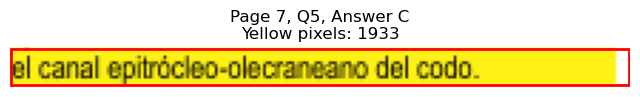

Page 7, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=396.3, y1=341.9
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 468
Page 7, Q5, D: Yellow percentage: 0.0%


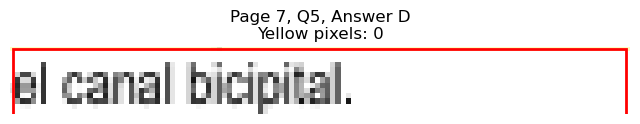


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=157.1, y1=379.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 569
Page 7, Q6, A: Yellow percentage: 0.0%


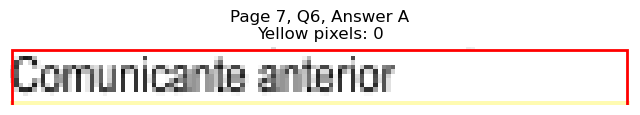

Page 7, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=161.5, y1=392.4
Page 7, Q6, B: Yellow pixels: 1357
Page 7, Q6, B: Total non-white pixels: 2016
Page 7, Q6, B: Yellow percentage: 67.3%


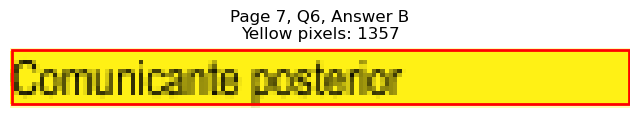

Page 7, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=357.7, y1=379.8
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 165
Page 7, Q6, C: Yellow percentage: 0.0%


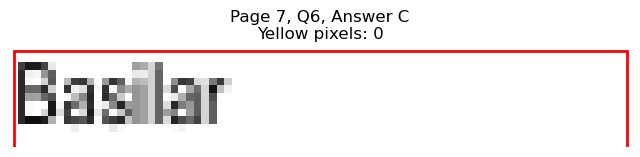

Page 7, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=366.7, y1=392.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 203
Page 7, Q6, D: Yellow percentage: 0.0%


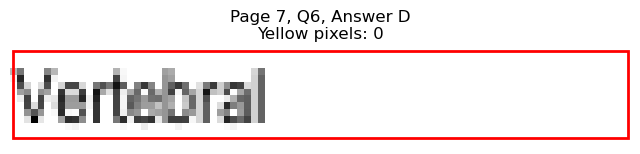


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=417.6, x1=133.5, y1=430.3
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 311
Page 7, Q7, A: Yellow percentage: 0.0%


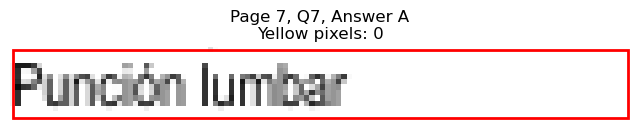

Page 7, Q7 - B: Detected box: x0=68.3, y0=430.2, x1=169.1, y1=442.9
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 517
Page 7, Q7, B: Yellow percentage: 0.0%


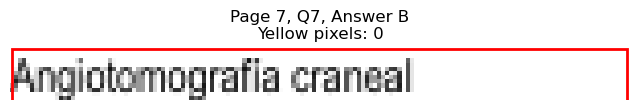

Page 7, Q7 - C: Detected box: x0=327.5, y0=417.6, x1=480.6, y1=430.3
Page 7, Q7, C: Yellow pixels: 204
Page 7, Q7, C: Total non-white pixels: 1007
Page 7, Q7, C: Yellow percentage: 20.3%


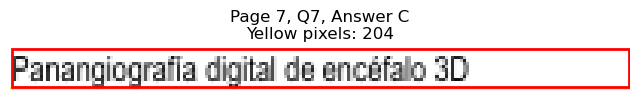

Page 7, Q7 - D: Detected box: x0=327.5, y0=430.2, x1=461.9, y1=442.9
Page 7, Q7, D: Yellow pixels: 1918
Page 7, Q7, D: Total non-white pixels: 2405
Page 7, Q7, D: Yellow percentage: 79.8%


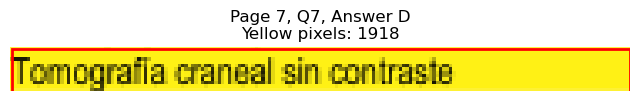


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=201.8, y1=493.4
Page 7, Q8, A: Yellow pixels: 184
Page 7, Q8, A: Total non-white pixels: 772
Page 7, Q8, A: Yellow percentage: 23.8%


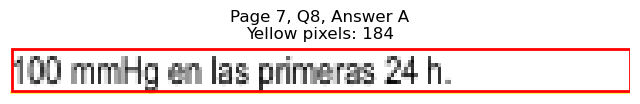

Page 7, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=201.8, y1=506.0
Page 7, Q8, B: Yellow pixels: 1924
Page 7, Q8, B: Total non-white pixels: 2396
Page 7, Q8, B: Yellow percentage: 80.3%


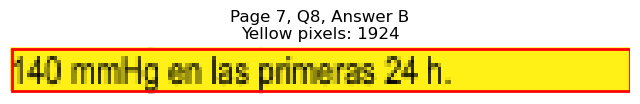

Page 7, Q8 - C: Detected box: x0=327.5, y0=480.8, x1=460.0, y1=493.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 628
Page 7, Q8, C: Yellow percentage: 0.0%


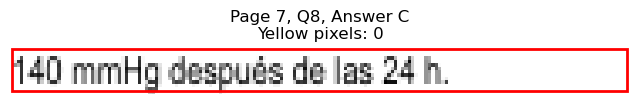

Page 7, Q8 - D: Detected box: x0=327.5, y0=493.4, x1=460.0, y1=506.0
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 624
Page 7, Q8, D: Yellow percentage: 0.0%


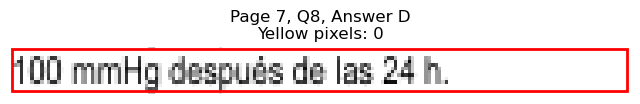


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=543.8, x1=130.5, y1=556.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 327
Page 7, Q9, A: Yellow percentage: 0.0%


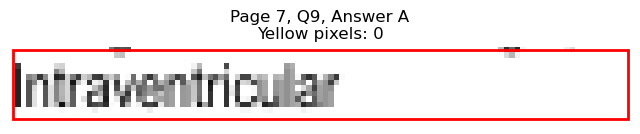

Page 7, Q9 - B: Detected box: x0=68.3, y0=556.5, x1=103.9, y1=569.2
Page 7, Q9, B: Yellow pixels: 983
Page 7, Q9, B: Total non-white pixels: 1204
Page 7, Q9, B: Yellow percentage: 81.6%


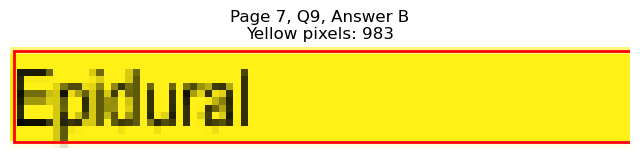

Page 7, Q9 - C: Detected box: x0=327.5, y0=543.8, x1=366.2, y1=556.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 189
Page 7, Q9, C: Yellow percentage: 0.0%


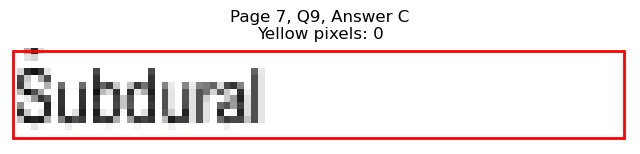

Page 7, Q9 - D: Detected box: x0=327.5, y0=556.5, x1=390.8, y1=569.2
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 314
Page 7, Q9, D: Yellow percentage: 0.0%


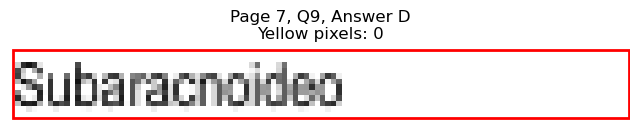


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=81.9, y1=619.6
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 52
Page 7, Q10, A: Yellow percentage: 0.0%


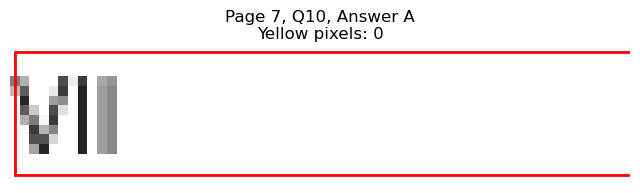

Page 7, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=84.4, y1=632.3
Page 7, Q10, B: Yellow pixels: 750
Page 7, Q10, B: Total non-white pixels: 938
Page 7, Q10, B: Yellow percentage: 80.0%


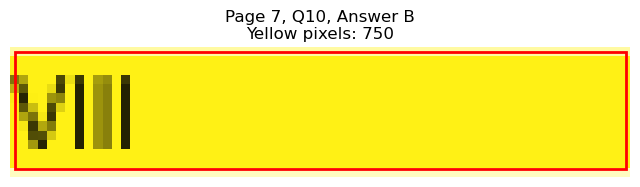

Page 7, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=338.6, y1=619.6
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 45
Page 7, Q10, C: Yellow percentage: 0.0%


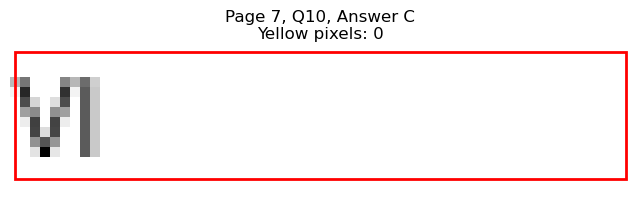

Page 7, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=338.6, y1=632.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 42
Page 7, Q10, D: Yellow percentage: 0.0%


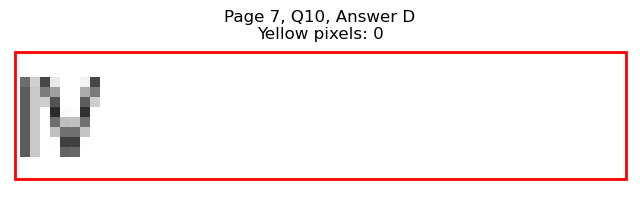


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=115.0, y1=670.1
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 220
Page 7, Q11, A: Yellow percentage: 0.0%


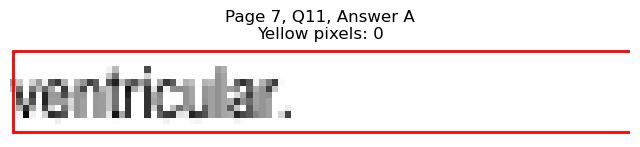

Page 7, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=107.9, y1=682.7
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 203
Page 7, Q11, B: Yellow percentage: 0.0%


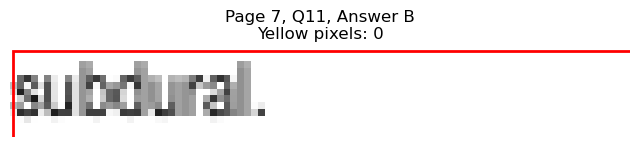

Page 7, Q11 - C: Detected box: x0=327.5, y0=657.5, x1=364.6, y1=670.1
Page 7, Q11, C: Yellow pixels: 88
Page 7, Q11, C: Total non-white pixels: 269
Page 7, Q11, C: Yellow percentage: 32.7%


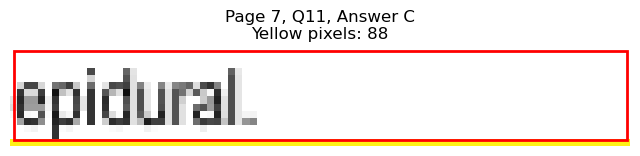

Page 7, Q11 - D: Detected box: x0=327.5, y0=670.1, x1=382.3, y1=682.7
Page 7, Q11, D: Yellow pixels: 1194
Page 7, Q11, D: Total non-white pixels: 1378
Page 7, Q11, D: Yellow percentage: 86.6%


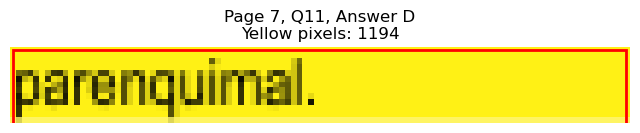


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)




Page 7, Q12 - A: Detected box: x0=68.3, y0=708.0, x1=88.8, y1=720.6
Page 7, Q12, A: Yellow pixels: 847
Page 7, Q12, A: Total non-white pixels: 994
Page 7, Q12, A: Yellow percentage: 85.2%


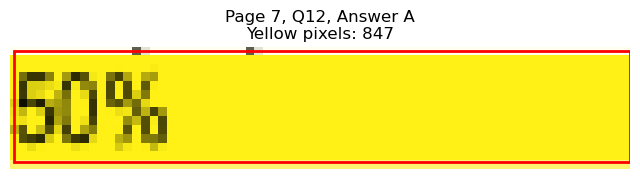

Page 7, Q12 - B: Detected box: x0=68.3, y0=720.6, x1=88.8, y1=733.2
Page 7, Q12, B: Yellow pixels: 71
Page 7, Q12, B: Total non-white pixels: 177
Page 7, Q12, B: Yellow percentage: 40.1%


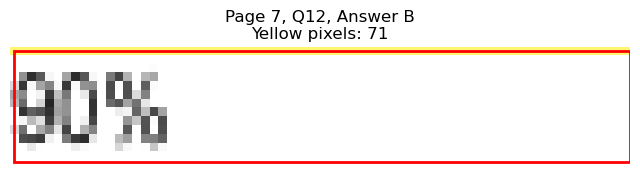

Page 7, Q12 - C: Detected box: x0=327.5, y0=708.0, x1=348.1, y1=720.6
Page 7, Q12, C: Yellow pixels: 0
Page 7, Q12, C: Total non-white pixels: 98
Page 7, Q12, C: Yellow percentage: 0.0%


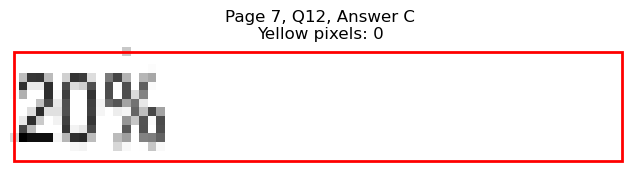

Page 7, Q12 - D: Detected box: x0=327.5, y0=720.6, x1=348.1, y1=733.2
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 83
Page 7, Q12, D: Yellow percentage: 0.0%


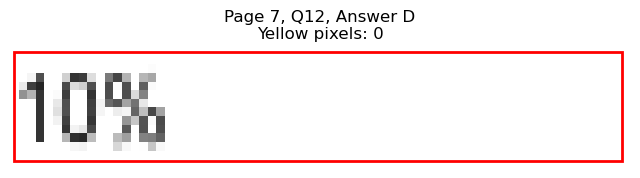


Page 7, Q12 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=127.5, y1=102.1
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 291
Page 8, Q1, A: Yellow percentage: 0.0%


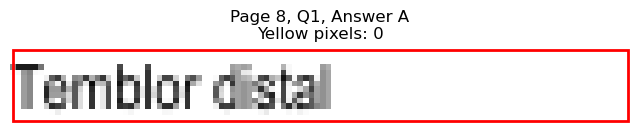

Page 8, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=108.4, y1=114.7
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 212
Page 8, Q1, B: Yellow percentage: 0.0%


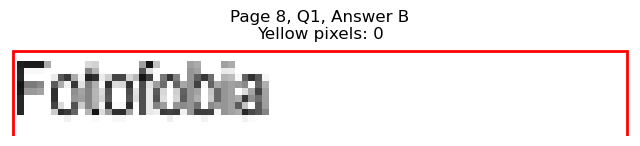

Page 8, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=377.7, y1=102.1
Page 8, Q1, C: Yellow pixels: 1126
Page 8, Q1, C: Total non-white pixels: 1414
Page 8, Q1, C: Yellow percentage: 79.6%


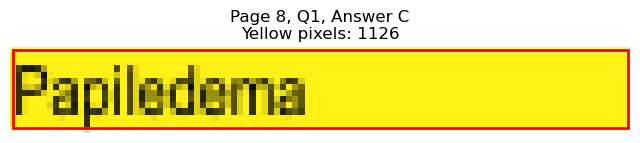

Page 8, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=358.6, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 251
Page 8, Q1, D: Yellow percentage: 0.0%


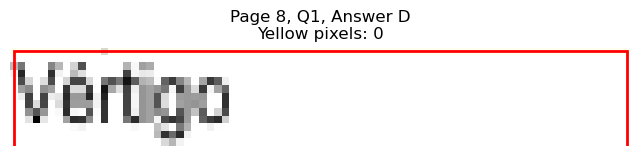


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=293.4, y1=165.2
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 1113
Page 8, Q2, A: Yellow percentage: 0.0%


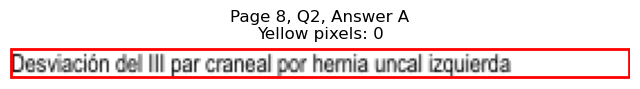

Page 8, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=261.9, y1=177.8
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 1192
Page 8, Q2, B: Yellow percentage: 0.0%


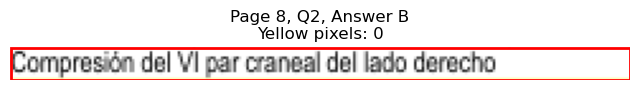

Page 8, Q2 - C: Detected box: x0=68.8, y0=177.7, x1=311.1, y1=190.4
Page 8, Q2, C: Yellow pixels: 2628
Page 8, Q2, C: Total non-white pixels: 4116
Page 8, Q2, C: Yellow percentage: 63.8%


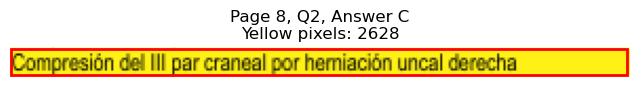

Page 8, Q2 - D: Detected box: x0=68.8, y0=190.3, x1=194.2, y1=203.0
Page 8, Q2, D: Yellow pixels: 3
Page 8, Q2, D: Total non-white pixels: 791
Page 8, Q2, D: Yellow percentage: 0.4%


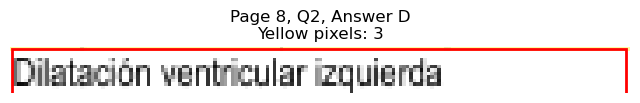


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=179.7, y1=266.1
Page 8, Q3, A: Yellow pixels: 1684
Page 8, Q3, A: Total non-white pixels: 2268
Page 8, Q3, A: Yellow percentage: 74.3%


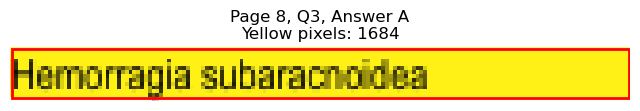

Page 8, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=187.6, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 753
Page 8, Q3, B: Yellow percentage: 0.0%


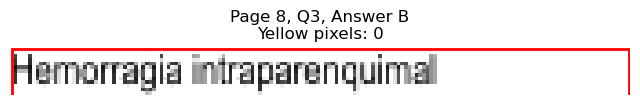

Page 8, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=447.4, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 656
Page 8, Q3, C: Yellow percentage: 0.0%


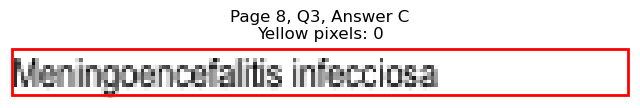

Page 8, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=463.9, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 722
Page 8, Q3, D: Yellow percentage: 0.0%


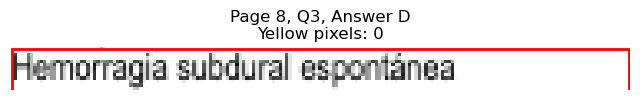


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=65.2, y1=316.7
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 127
Page 8, Q4, A: Yellow percentage: 0.0%


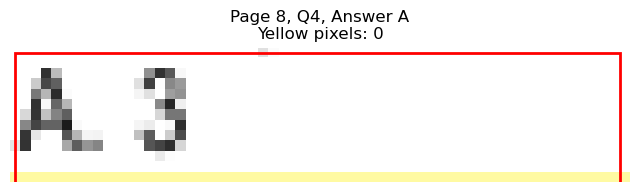

Page 8, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=65.2, y1=329.3
Page 8, Q4, B: Yellow pixels: 666
Page 8, Q4, B: Total non-white pixels: 840
Page 8, Q4, B: Yellow percentage: 79.3%


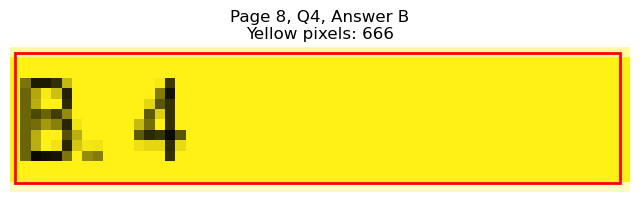

Page 8, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=324.4, y1=316.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 65
Page 8, Q4, C: Yellow percentage: 0.0%


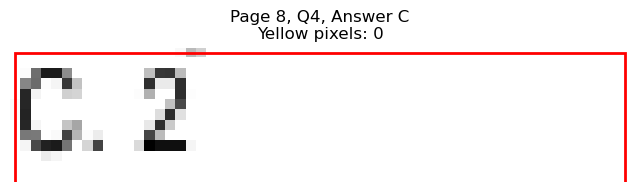

Page 8, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=324.4, y1=329.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 53
Page 8, Q4, D: Yellow percentage: 0.0%


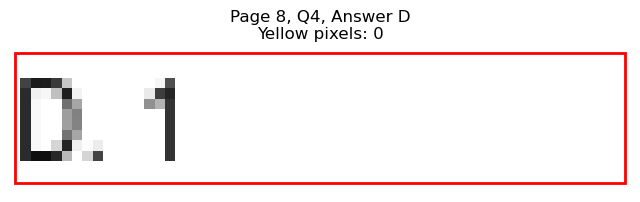


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=209.2, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 748
Page 8, Q5, A: Yellow percentage: 0.0%


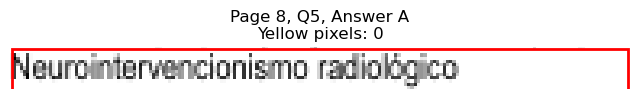

Page 8, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=156.6, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 459
Page 8, Q5, B: Yellow percentage: 0.0%


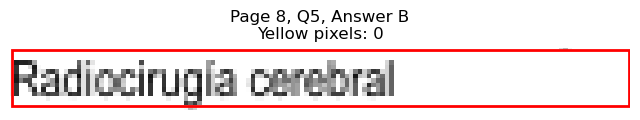

Page 8, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=400.7, y1=379.8
Page 8, Q5, C: Yellow pixels: 2
Page 8, Q5, C: Total non-white pixels: 507
Page 8, Q5, C: Yellow percentage: 0.4%


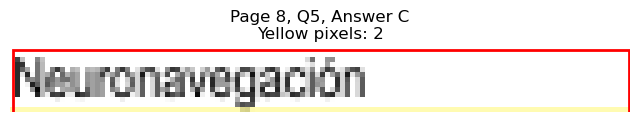

Page 8, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=476.5, y1=392.4
Page 8, Q5, D: Yellow pixels: 1813
Page 8, Q5, D: Total non-white pixels: 2800
Page 8, Q5, D: Yellow percentage: 64.8%


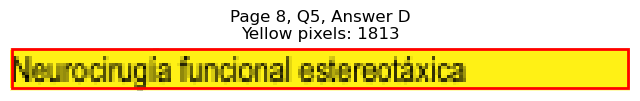


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=99.9, y1=430.3
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 177
Page 8, Q6, A: Yellow percentage: 0.0%


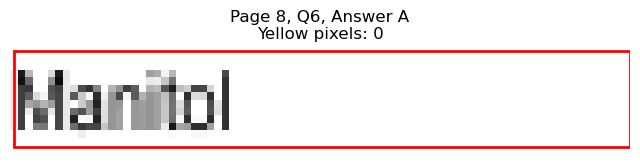

Page 8, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=118.5, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 251
Page 8, Q6, B: Yellow percentage: 0.0%


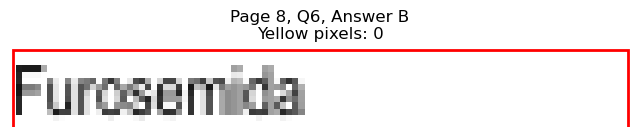

Page 8, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=350.1, y1=430.3
Page 8, Q6, C: Yellow pixels: 74
Page 8, Q6, C: Total non-white pixels: 173
Page 8, Q6, C: Yellow percentage: 42.8%


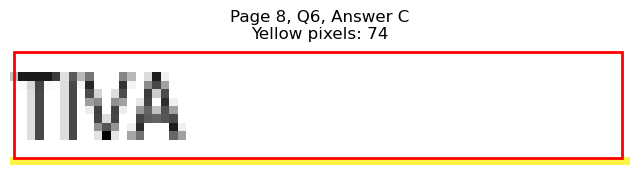

Page 8, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=361.6, y1=442.9
Page 8, Q6, D: Yellow pixels: 952
Page 8, Q6, D: Total non-white pixels: 1105
Page 8, Q6, D: Yellow percentage: 86.2%


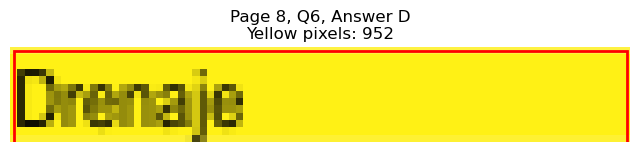


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=206.2, y1=480.7
Page 8, Q7, A: Yellow pixels: 1911
Page 8, Q7, A: Total non-white pixels: 2457
Page 8, Q7, A: Yellow percentage: 77.8%


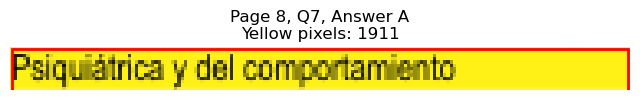

Page 8, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=177.1, y1=493.4
Page 8, Q7, B: Yellow pixels: 159
Page 8, Q7, B: Total non-white pixels: 737
Page 8, Q7, B: Yellow percentage: 21.6%


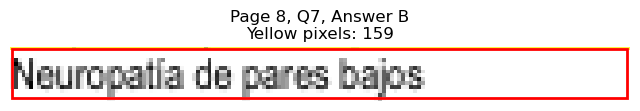

Page 8, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=380.7, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 274
Page 8, Q7, C: Yellow percentage: 0.0%


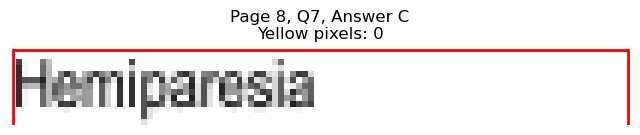

Page 8, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=377.7, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 283
Page 8, Q7, D: Yellow percentage: 0.0%


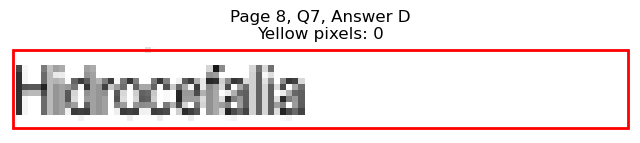


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=121.5, y1=543.8
Page 8, Q8, A: Yellow pixels: 1122
Page 8, Q8, A: Total non-white pixels: 1352
Page 8, Q8, A: Yellow percentage: 83.0%


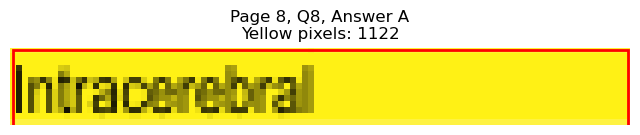

Page 8, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=113.9, y1=556.4
Page 8, Q8, B: Yellow pixels: 96
Page 8, Q8, B: Total non-white pixels: 304
Page 8, Q8, B: Yellow percentage: 31.6%


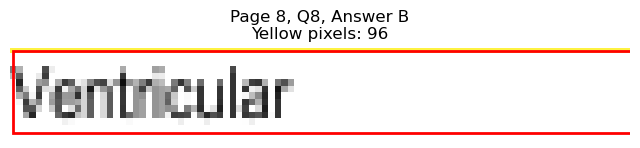

Page 8, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=366.2, y1=543.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 187
Page 8, Q8, C: Yellow percentage: 0.0%


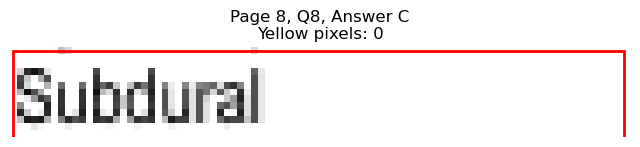

Page 8, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=363.2, y1=556.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 166
Page 8, Q8, D: Yellow percentage: 0.0%


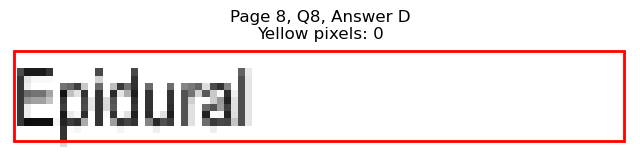


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=235.4, y1=594.4
Page 8, Q9, A: Yellow pixels: 218
Page 8, Q9, A: Total non-white pixels: 1051
Page 8, Q9, A: Yellow percentage: 20.7%


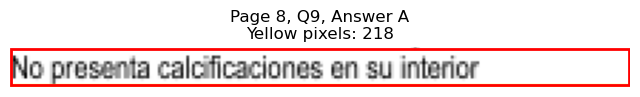

Page 8, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=288.0, y1=607.0
Page 8, Q9, B: Yellow pixels: 2700
Page 8, Q9, B: Total non-white pixels: 3523
Page 8, Q9, B: Yellow percentage: 76.6%


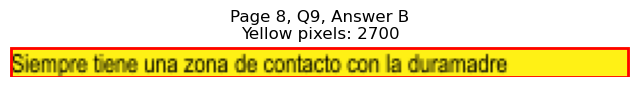

Page 8, Q9 - C: Detected box: x0=68.8, y0=606.9, x1=161.5, y1=619.6
Page 8, Q9, C: Yellow pixels: 142
Page 8, Q9, C: Total non-white pixels: 614
Page 8, Q9, C: Yellow percentage: 23.1%


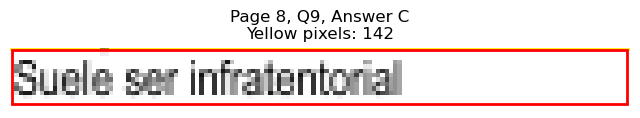

Page 8, Q9 - D: Detected box: x0=68.8, y0=619.6, x1=154.6, y1=632.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 404
Page 8, Q9, D: Yellow percentage: 0.0%


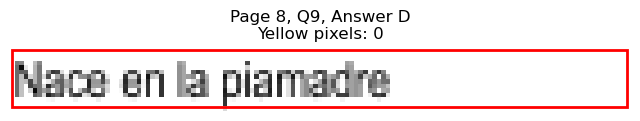


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=168.6, y1=670.1
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 527
Page 8, Q10, A: Yellow percentage: 0.0%


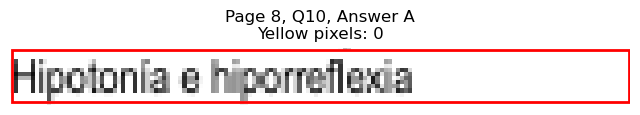

Page 8, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=173.1, y1=682.7
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 536
Page 8, Q10, B: Yellow percentage: 0.0%


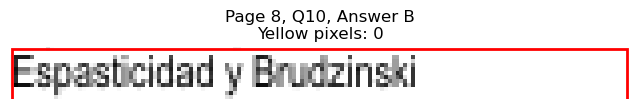

Page 8, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=448.4, y1=670.1
Page 8, Q10, C: Yellow pixels: 172
Page 8, Q10, C: Total non-white pixels: 774
Page 8, Q10, C: Yellow percentage: 22.2%


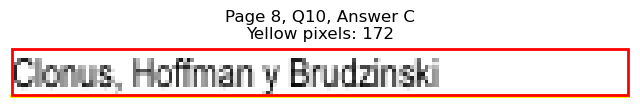

Page 8, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=479.0, y1=682.7
Page 8, Q10, D: Yellow pixels: 2017
Page 8, Q10, D: Total non-white pixels: 2639
Page 8, Q10, D: Yellow percentage: 76.4%


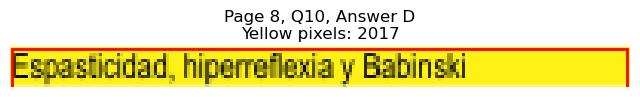


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=192.6, y1=745.8
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 802
Page 8, Q11, A: Yellow percentage: 0.0%


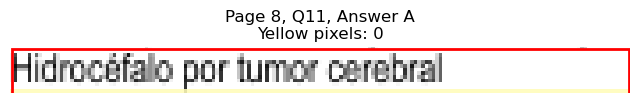

Page 8, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=259.4, y1=758.4
Page 8, Q11, B: Yellow pixels: 2011
Page 8, Q11, B: Total non-white pixels: 2996
Page 8, Q11, B: Yellow percentage: 67.1%


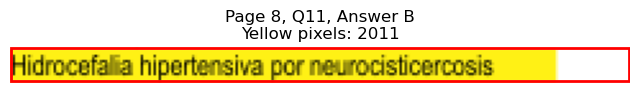

Page 8, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=491.0, y1=745.8
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 800
Page 8, Q11, C: Yellow percentage: 0.0%


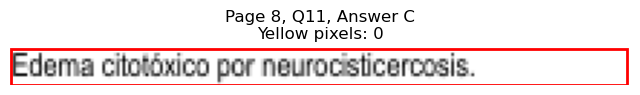

Page 8, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=480.5, y1=758.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 765
Page 8, Q11, D: Yellow percentage: 0.0%


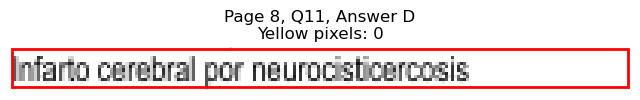


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=248.8, y1=102.1
Page 9, Q1, A: Yellow pixels: 2061
Page 9, Q1, A: Total non-white pixels: 2996
Page 9, Q1, A: Yellow percentage: 68.8%


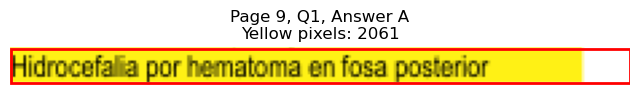

Page 9, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=215.7, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 947
Page 9, Q1, B: Yellow percentage: 0.0%


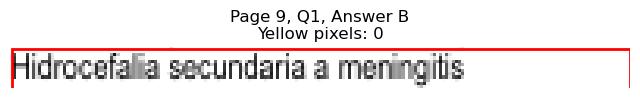

Page 9, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=443.8, y1=102.1
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 603
Page 9, Q1, C: Yellow percentage: 0.0%


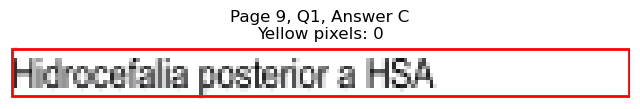

Page 9, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=414.3, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 432
Page 9, Q1, D: Yellow percentage: 0.0%


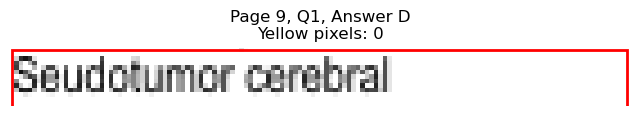


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=182.2, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 591
Page 9, Q2, A: Yellow percentage: 0.0%


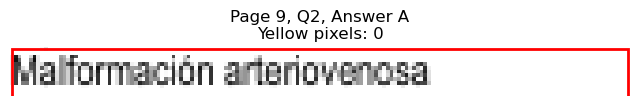

Page 9, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=168.6, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 490
Page 9, Q2, B: Yellow percentage: 0.0%


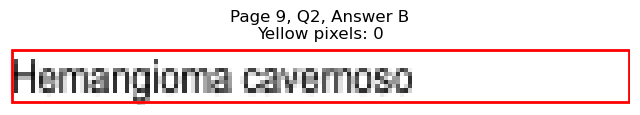

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=438.4, y1=177.8
Page 9, Q2, C: Yellow pixels: 2
Page 9, Q2, C: Total non-white pixels: 700
Page 9, Q2, C: Yellow percentage: 0.3%


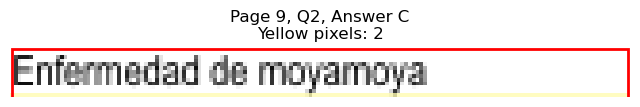

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=397.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 1201
Page 9, Q2, D: Total non-white pixels: 1694
Page 9, Q2, D: Yellow percentage: 70.9%


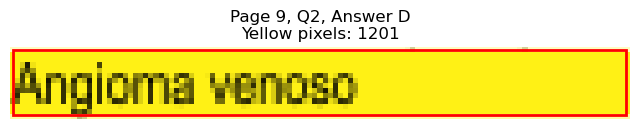


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=145.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 361
Page 9, Q3, A: Yellow percentage: 0.0%


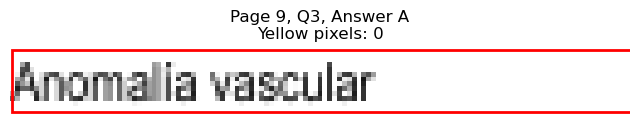

Page 9, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=149.1, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 375
Page 9, Q3, B: Yellow percentage: 0.0%


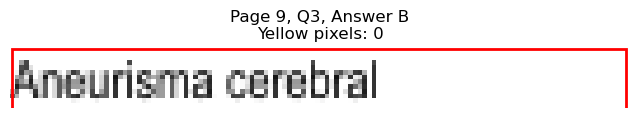

Page 9, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=410.8, y1=228.3
Page 9, Q3, C: Yellow pixels: 1241
Page 9, Q3, C: Total non-white pixels: 1876
Page 9, Q3, C: Yellow percentage: 66.2%


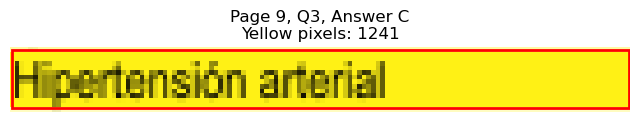

Page 9, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=441.4, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 748
Page 9, Q3, D: Yellow percentage: 0.0%


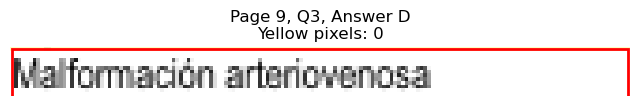


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=161.7, y1=278.7
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 455
Page 9, Q4, A: Yellow percentage: 0.0%


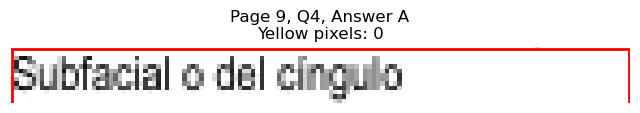

Page 9, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=170.2, y1=291.5
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 516
Page 9, Q4, B: Yellow percentage: 0.0%


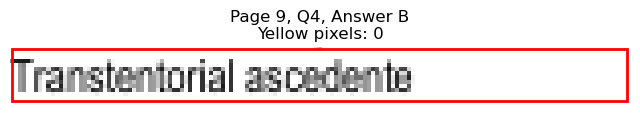

Page 9, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=439.4, y1=278.7
Page 9, Q4, C: Yellow pixels: 1671
Page 9, Q4, C: Total non-white pixels: 2119
Page 9, Q4, C: Yellow percentage: 78.9%


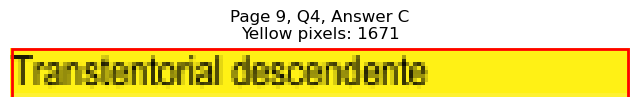

Page 9, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=492.6, y1=291.5
Page 9, Q4, D: Yellow pixels: 213
Page 9, Q4, D: Total non-white pixels: 1077
Page 9, Q4, D: Yellow percentage: 19.8%


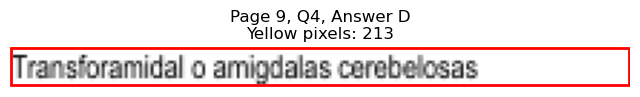


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=177.6, y1=329.3
Page 9, Q5, A: Yellow pixels: 160
Page 9, Q5, A: Total non-white pixels: 692
Page 9, Q5, A: Yellow percentage: 23.1%


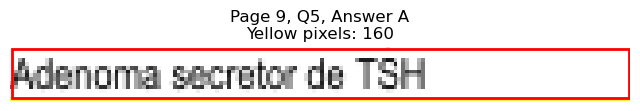

Page 9, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=123.5, y1=341.9
Page 9, Q5, B: Yellow pixels: 1164
Page 9, Q5, B: Total non-white pixels: 1378
Page 9, Q5, B: Yellow percentage: 84.5%


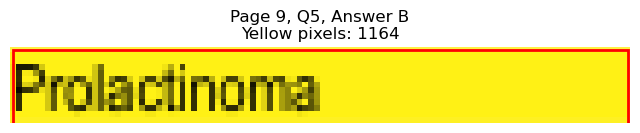

Page 9, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=515.7, y1=329.3
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 881
Page 9, Q5, C: Yellow percentage: 0.0%


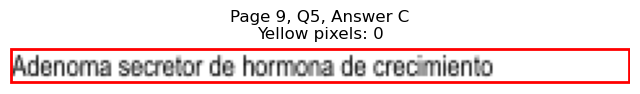

Page 9, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=416.3, y1=341.9
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 405
Page 9, Q5, D: Yellow percentage: 0.0%


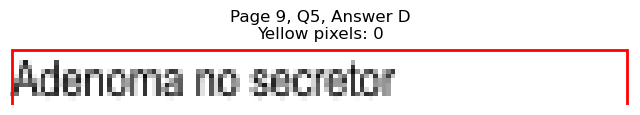


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=177.6, y1=392.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 517
Page 9, Q6, A: Yellow percentage: 0.0%


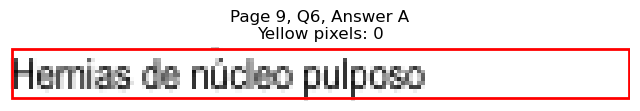

Page 9, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=185.7, y1=405.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 632
Page 9, Q6, B: Yellow percentage: 0.0%


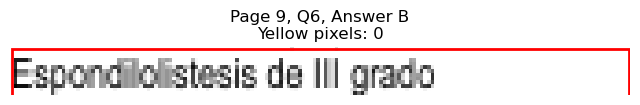

Page 9, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=434.8, y1=392.4
Page 9, Q6, C: Yellow pixels: 1477
Page 9, Q6, C: Total non-white pixels: 2212
Page 9, Q6, C: Yellow percentage: 66.8%


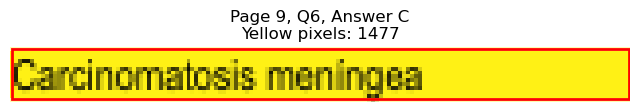

Page 9, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=449.5, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 777
Page 9, Q6, D: Yellow percentage: 0.0%


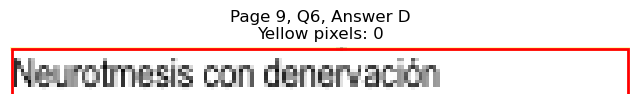


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=78.4, y1=455.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 38
Page 9, Q7, A: Yellow percentage: 0.0%


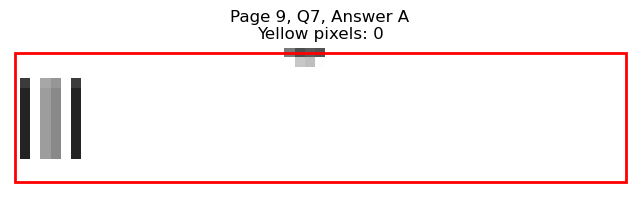

Page 9, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=79.3, y1=468.1
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 36
Page 9, Q7, B: Yellow percentage: 0.0%


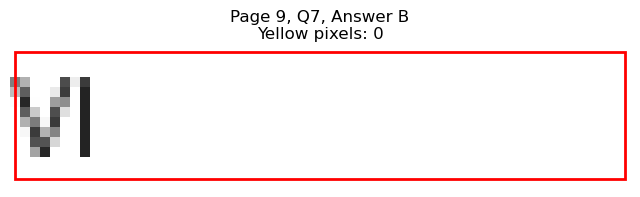

Page 9, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=338.6, y1=455.5
Page 9, Q7, C: Yellow pixels: 766
Page 9, Q7, C: Total non-white pixels: 868
Page 9, Q7, C: Yellow percentage: 88.2%


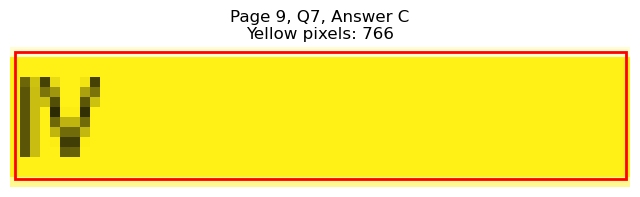

Page 9, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=324.4, y1=468.1
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 72
Page 9, Q7, D: Yellow percentage: 0.0%


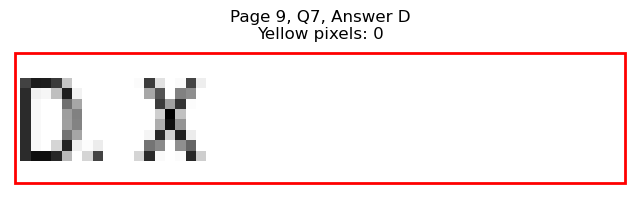


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=93.9, y1=531.2
Page 9, Q8, A: Yellow pixels: 894
Page 9, Q8, A: Total non-white pixels: 1064
Page 9, Q8, A: Yellow percentage: 84.0%


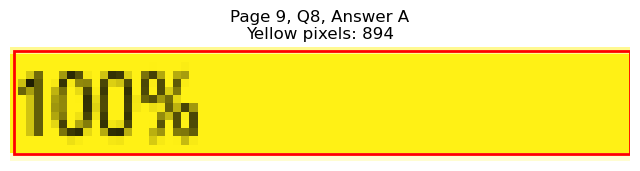

Page 9, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=88.8, y1=543.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 177
Page 9, Q8, B: Yellow percentage: 0.0%


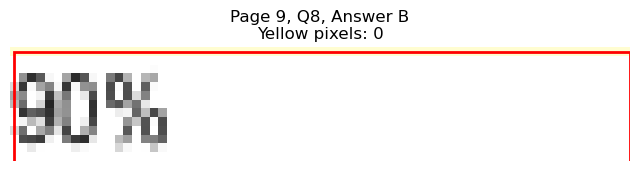

Page 9, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=348.1, y1=531.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 102
Page 9, Q8, C: Yellow percentage: 0.0%


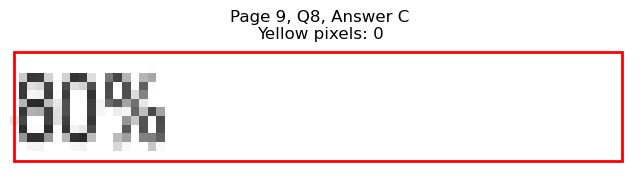

Page 9, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=348.1, y1=543.8
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 92
Page 9, Q8, D: Yellow percentage: 0.0%


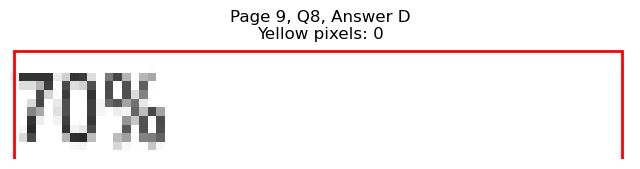


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=148.0, y1=594.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 416
Page 9, Q9, A: Yellow percentage: 0.0%


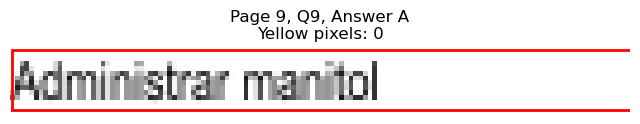

Page 9, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=182.7, y1=607.0
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 558
Page 9, Q9, B: Yellow percentage: 0.0%


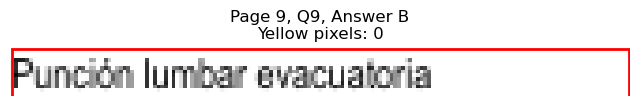

Page 9, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=449.9, y1=594.4
Page 9, Q9, C: Yellow pixels: 1590
Page 9, Q9, C: Total non-white pixels: 2422
Page 9, Q9, C: Yellow percentage: 65.6%


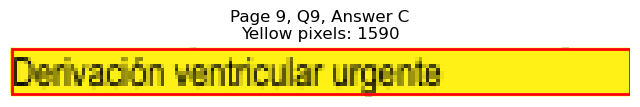

Page 9, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=421.3, y1=607.0
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 627
Page 9, Q9, D: Yellow percentage: 0.0%


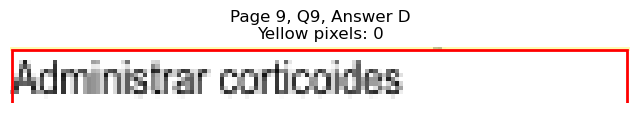


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=116.9, y1=644.9
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 327
Page 9, Q10, A: Yellow percentage: 0.0%


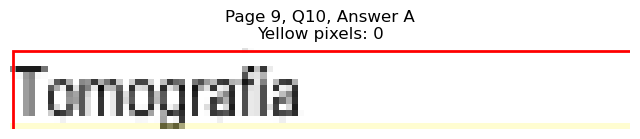

Page 9, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=118.5, y1=657.5
Page 9, Q10, B: Yellow pixels: 1125
Page 9, Q10, B: Total non-white pixels: 1414
Page 9, Q10, B: Yellow percentage: 79.6%


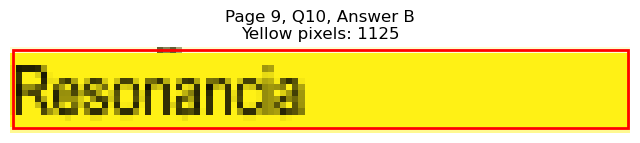

Page 9, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=376.3, y1=644.9
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 242
Page 9, Q10, C: Yellow percentage: 0.0%


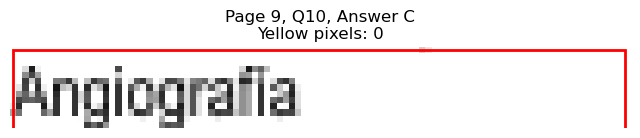

Page 9, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=362.1, y1=657.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 169
Page 9, Q10, D: Yellow percentage: 0.0%


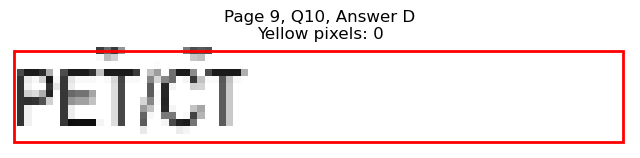


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=133.9, y1=720.6
Page 9, Q11, A: Yellow pixels: 1231
Page 9, Q11, A: Total non-white pixels: 1624
Page 9, Q11, A: Yellow percentage: 75.8%


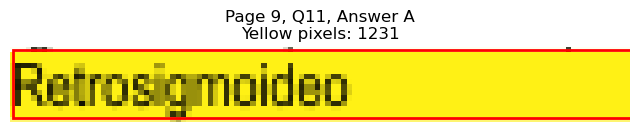

Page 9, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=149.1, y1=733.2
Page 9, Q11, B: Yellow pixels: 131
Page 9, Q11, B: Total non-white pixels: 555
Page 9, Q11, B: Yellow percentage: 23.6%


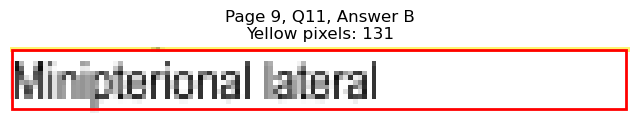

Page 9, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=449.9, y1=720.6
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 620
Page 9, Q11, C: Yellow percentage: 0.0%


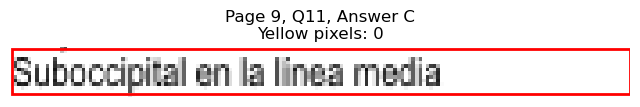

Page 9, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=448.0, y1=733.2
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 667
Page 9, Q11, D: Yellow percentage: 0.0%


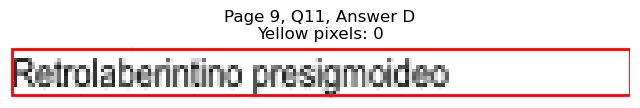


Page 9, Q11 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 3 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=356.1, y1=127.3
Page 10, Q1, A: Yellow pixels: 339
Page 10, Q1, A: Total non-white pixels: 1758
Page 10, Q1, A: Yellow percentage: 19.3%


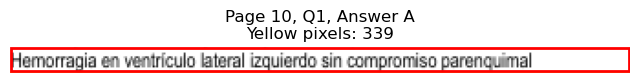

Page 10, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=393.8, y1=139.9
Page 10, Q1, B: Yellow pixels: 3596
Page 10, Q1, B: Total non-white pixels: 4888
Page 10, Q1, B: Yellow percentage: 73.6%


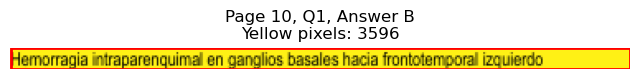

Page 10, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=311.0, y1=152.6
Page 10, Q1, C: Yellow pixels: 277
Page 10, Q1, C: Total non-white pixels: 1588
Page 10, Q1, C: Yellow percentage: 17.4%


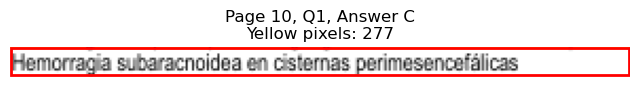

Page 10, Q1 - D: Detected box: x0=68.8, y0=152.5, x1=260.9, y1=165.2
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 984
Page 10, Q1, D: Yellow percentage: 0.0%


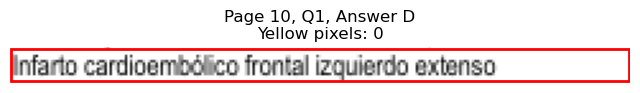


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=144.0, y1=203.0
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 468
Page 10, Q2, A: Yellow percentage: 0.0%


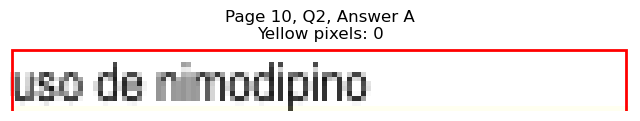

Page 10, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=182.2, y1=215.6
Page 10, Q2, B: Yellow pixels: 1725
Page 10, Q2, B: Total non-white pixels: 2310
Page 10, Q2, B: Yellow percentage: 74.7%


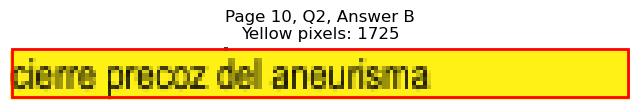

Page 10, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=445.9, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 586
Page 10, Q2, C: Yellow percentage: 0.0%


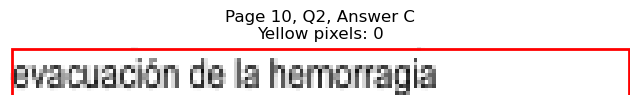

Page 10, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=437.8, y1=215.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 579
Page 10, Q2, D: Yellow percentage: 0.0%


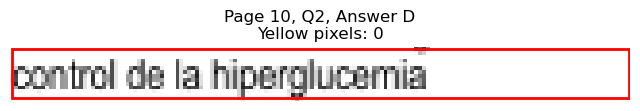


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=99.4, y1=253.5
Page 10, Q3, A: Yellow pixels: 942
Page 10, Q3, A: Total non-white pixels: 1148
Page 10, Q3, A: Yellow percentage: 82.1%


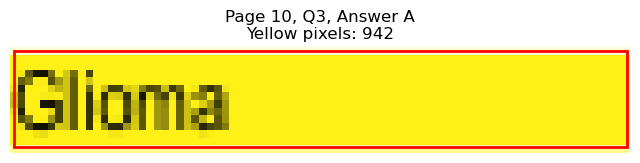

Page 10, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=148.6, y1=266.1
Page 10, Q3, B: Yellow pixels: 131
Page 10, Q3, B: Total non-white pixels: 537
Page 10, Q3, B: Yellow percentage: 24.4%


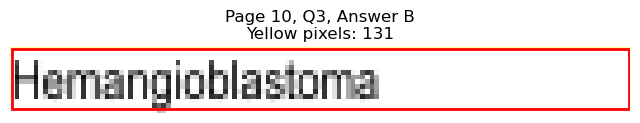

Page 10, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=396.3, y1=253.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 380
Page 10, Q3, C: Yellow percentage: 0.0%


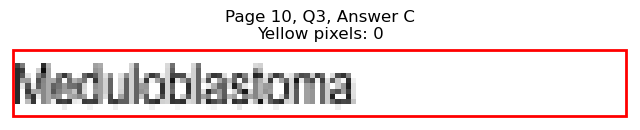

Page 10, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=384.7, y1=266.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 289
Page 10, Q3, D: Yellow percentage: 0.0%


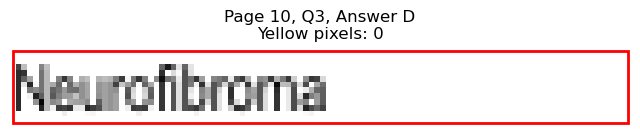


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 66 años usuaria de corticoides y AINE...
1   ¿Cuál es el punto más prominente del hueso occ...
2   La TC craneal tiene una sensibilidad de detecc...
3   Niño de 15 años, con cefalea post TEC. TC de c...
4   Varón de 69 años, ingresa por cefalea persiste...
..                                                ...
95  ¿Cuál es la prueba más sensible para diagnósti...
96  Mujer adulta, con dolor tipo quemazón en hemic...
97  Varón de 84 años con antecedentes de fibrilaci...
98  En el tratamiento de la HSA, el riesgo de resa...
99      ¿Cuál es el tumor intramedular más frecuente?

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                 Fractura traumática   
1                                            Asterion   
2                                                100%   
3                               Edema cerebral difuso   
4                                        Osteosarcoma   
..                                                ...   
95                                         Tomografía   
96                                     Retrosigmoideo   
97  Hemorragia en ventrículo lateral izquierdo sin...   
98                                  uso de nimodipino   
99                                             Glioma   

                                             option_B  \
0                           Fractura por osteoporosis   
1                                       Opistocranion   
2                                                 50%   
3                                Lesión axonal difusa   
4                                      Adenocarcinoma   
..                                                ...   
95                                         Resonancia   
96                              Minipterional lateral   
97  Hemorragia intraparenquimal en ganglios basale...   
98                        cierre precoz del aneurisma   
99                                   Hemangioblastoma   

                                             option_C  \
0                                          Metástasis   
1                                               Inion   
2                                                 40%   
3                                     Infarto lacunar   
4                                             Linfoma   
..                                                ...   
95                                        Angiografía   
96                     Suboccipital en la línea media   
97  Hemorragia subaracnoidea en cisternas perimese...   
98                        evacuación de la hemorragia   
99                                     Meduloblastoma   

                                            option_D  
0                            Fractura en tallo verde  
1                                            Pterion  
2                                                30%  
3                                 Aneurisma arterial  
4                                           Melanoma  
..                                               ...  
95                                            PET/CT  
96                     Retrolaberintino presigmoideo  
97  Infarto cardioembólico frontal izquierdo extenso  
98                       control de la hiperglucemia  
99                                      Neurofibroma  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 66 años usuaria de corticoides y AINE...   
1   ¿Cuál es el punto más prominente del hueso occ...   
2   La TC craneal tiene una sensibilidad de detecc...   
3   Niño de 15 años, con cefalea post TEC. TC de c...   
4   Varón de 69 años, ingresa por cefalea persiste...   
..                                                ...   
95  ¿Cuál es la prueba más sensible para diagnósti...   
96  Mujer adulta, con dolor tipo quemazón en hemic...   
97  Varón de 84 años con antecedentes de fibrilaci...   
98  En el tratamiento de la HSA, el riesgo de resa...   
99      ¿Cuál es el tumor intramedular más frecuente?   

                                             option_A  \
0                                 Fractura traumática   
1                                            Asterion   
2                                                100%   
3                               Edema cerebral difuso   
4                                        Osteosarcoma   
..                                                ...   
95                                         Tomografía   
96                                     Retrosigmoideo   
97  Hemorragia en ventrículo lateral izquierdo sin...   
98                                  uso de nimodipino   
99                                             Glioma   

                                             option_B  \
0                           Fractura por osteoporosis   
1                                       Opistocranion   
2                                                 50%   
3                                Lesión axonal difusa   
4                                      Adenocarcinoma   
..                                                ...   
95                                         Resonancia   
96                              Minipterional lateral   
97  Hemorragia intraparenquimal en ganglios basale...   
98                        cierre precoz del aneurisma   
99                                   Hemangioblastoma   

                                             option_C  \
0                                          Metástasis   
1                                               Inion   
2                                                 40%   
3                                     Infarto lacunar   
4                                             Linfoma   
..                                                ...   
95                                        Angiografía   
96                     Suboccipital en la línea media   
97  Hemorragia subaracnoidea en cisternas perimese...   
98                        evacuación de la hemorragia   
99                                     Meduloblastoma   

                                            option_D correct_answer  
0                            Fractura en tallo verde              B  
1                                            Pterion              B  
2                                                30%              A  
3                                 Aneurisma arterial              A  
4                                           Melanoma              D  
..                                               ...            ...  
95                                            PET/CT              B  
96                     Retrolaberintino presigmoideo              A  
97  Infarto cardioembólico frontal izquierdo extenso              B  
98                       control de la hiperglucemia              B  
99                                      Neurofibroma              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/NEUROCIRUGÍA.csv
